# Pure FNO (NeuralOperator) — 1D x(t) → y(t) training notebook (leakage-safe)

This notebook trains a **pure FNO-1D** to learn **x(t) → y(t)**.

Key fixes / features:
- **Train/Val/Test split happens BEFORE preprocessing**.
- **Normalization stats are computed using TRAIN ONLY** (prevents data leakage).
- Optional preprocessing toggles:
  - `remove_dc` (subtract mean per-sample)
  - `normalize` (`none` / `standard` / `maxabs`) — train-only stats
  - `per_sample_rms` (optional)
  - `add_time_channel` (adds a normalized time coordinate to **X only**)
- Quick sanity checks include:
  - time-domain plot
  - **linear** FFT magnitude (no semilogy)
  - phase (wrapped) + **phase difference** (masked where magnitude is tiny)

Assumption: your segment is **0.3 seconds** (e.g., [0, 0.3] s).  
If `T=57600`, then `fs = 57600 / 0.3 = 192000 Hz`.


## 0) Setup

In [ ]:

# If needed (fresh env), uncomment:
# !pip -q install neuraloperator torch numpy scipy matplotlib tqdm soundfile

import os, json, random, math
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Optional, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt``

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Torch: 2.5.1
CUDA: True


c:\Users\Euije Lee\anaconda3\envs\p311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

## 1) Load data

Choose one:
- **Option A (recommended)**: `.npz` with arrays `X` and `Y`
  - `X`: `[N,T]` or `[N,C_in,T]`
  - `Y`: `[N,T]` or `[N,C_out,T]`
- **Option B**: paired WAV folders (`x_dir`, `y_dir`) matched by filename stem


In [4]:

def ensure_3d(arr: np.ndarray) -> np.ndarray:
    """Convert to [N, C, T]. Accepts [N,T] or [N,C,T]."""
    arr = np.asarray(arr)
    if arr.ndim == 2:
        return arr[:, None, :]
    if arr.ndim == 3:
        return arr
    raise ValueError(f"Expected 2D or 3D array, got shape {arr.shape}")

def load_npz(npz_path: str, x_key="X", y_key="Y") -> Tuple[np.ndarray, np.ndarray, Dict]:
    npz = np.load(npz_path, allow_pickle=True)
    X = ensure_3d(npz[x_key]).astype(np.float32)
    Y = ensure_3d(npz[y_key]).astype(np.float32)
    meta = {}
    for k in npz.files:
        if k not in (x_key, y_key):
            try:
                meta[k] = npz[k].item() if npz[k].dtype == object else npz[k]
            except Exception:
                pass
    return X, Y, meta

def load_wav_pairs(x_dir: str, y_dir: str, sr_expected: Optional[int]=None) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """Load paired wav files from x_dir and y_dir. Matching is by filename stem."""
    try:
        import soundfile as sf
        def read_fn(p):
            data, sr = sf.read(p, dtype="float32")
            return sr, data
    except Exception:
        from scipy.io import wavfile
        def read_fn(p):
            sr, data = wavfile.read(p)
            data = data.astype(np.float32)
            if data.dtype.kind in ("i", "u"):
                maxv = np.iinfo(data.dtype).max
                data = data / maxv
            return sr, data

    x_dir = Path(x_dir)
    y_dir = Path(y_dir)
    x_files = sorted(x_dir.glob("*.wav"))
    if not x_files:
        raise FileNotFoundError(f"No wav files found in {x_dir}")

    y_map = {p.stem: p for p in y_dir.glob("*.wav")}
    pairs = [(xf, y_map.get(xf.stem)) for xf in x_files if xf.stem in y_map]
    if not pairs:
        raise FileNotFoundError("No matching wav stems found between x_dir and y_dir.")

    X_list, Y_list = [], []
    sr0 = None
    for xf, yf in tqdm(pairs, desc="Loading WAV pairs"):
        sr_x, x = read_fn(str(xf))
        sr_y, y = read_fn(str(yf))
        if sr_x != sr_y:
            raise ValueError(f"Sample rate mismatch for {xf.name}: x={sr_x}, y={sr_y}")
        if sr0 is None:
            sr0 = sr_x
        if sr_expected is not None and sr_x != sr_expected:
            raise ValueError(f"Expected sr={sr_expected}, got {sr_x} for {xf.name}")

        x = np.asarray(x).squeeze()
        y = np.asarray(y).squeeze()
        if x.ndim > 1: x = x[:, 0]
        if y.ndim > 1: y = y[:, 0]

        X_list.append(x[None, :])
        Y_list.append(y[None, :])

    T = min(min(a.shape[-1] for a in X_list), min(b.shape[-1] for b in Y_list))
    X = np.stack([a[..., :T] for a in X_list], axis=0).astype(np.float32)
    Y = np.stack([b[..., :T] for b in Y_list], axis=0).astype(np.float32)

    meta = {"sample_rate": int(sr0), "T": int(T), "N": int(X.shape[0])}
    return X, Y, meta

USE_LOADER = "wav"  # "npz" or "wav"

NPZ_PATH = "./data_xy.npz"   # <-- change

X_WAV_DIR = "./data/x_t"       # <-- change
Y_WAV_DIR = "./data/y_t"      # <-- change
SR_EXPECTED = None           # e.g., 48000

if USE_LOADER == "npz":
    X, Y, meta = load_npz(NPZ_PATH, x_key="X", y_key="Y")
else:
    X, Y, meta = load_wav_pairs(X_WAV_DIR, Y_WAV_DIR, sr_expected=SR_EXPECTED)

print("Loaded:")
print("  X:", X.shape, X.dtype)
print("  Y:", Y.shape, Y.dtype)
print("  meta keys:", list(meta.keys()))


Loading WAV pairs: 100%|██████████| 2322/2322 [00:00<00:00, 3143.97it/s]


Loaded:
  X: (2322, 1, 57600) float32
  Y: (2322, 1, 57600) float32
  meta keys: ['sample_rate', 'T', 'N']


## 2) Resolve sample rate and duration

In [5]:
# --- Step 2) Resolve sample rate and duration (+ optional resampling to 48k) ---
from scipy.signal import resample_poly

SEG_DUR_SEC = 0.3         # you said data is [0, 0.3] sec
TARGET_FS   = 48000       # resample target

# 1) resolve fs_in
T_in = X.shape[-1]
if "sample_rate" in meta:
    fs_in = int(meta["sample_rate"])
    print("fs_in from meta:", fs_in)
else:
    fs_in = int(round(T_in / SEG_DUR_SEC))
    print("fs_in inferred from T/duration:", fs_in)

print("Before resample:")
print("  X:", X.shape, "Y:", Y.shape)
print("  fs_in:", fs_in, "duration:", T_in / fs_in, "sec")

# 2) resample if needed (vectorized over axis=-1)
if fs_in != TARGET_FS:
    g = math.gcd(fs_in, TARGET_FS)
    up = TARGET_FS // g
    down = fs_in // g
    print(f"Resampling: {fs_in} -> {TARGET_FS} (up={up}, down={down})")

    # [N, C, T] resampling along time axis
    X = resample_poly(X, up, down, axis=-1).astype(np.float32)
    Y = resample_poly(Y, up, down, axis=-1).astype(np.float32)

    meta["sample_rate"] = TARGET_FS

# 3) final fs and duration
fs = int(meta["sample_rate"]) if "sample_rate" in meta else TARGET_FS
T = X.shape[-1]

print("After resample:")
print("  X:", X.shape, "Y:", Y.shape)
print("  fs:", fs, "duration:", T / fs, "sec")

# After resample, before split
KEEP_FRAC = 0.1  # 1/5
T = X.shape[-1]
T_keep = int(T * KEEP_FRAC)

X = X[..., :T_keep]
Y = Y[..., :T_keep]

T = X.shape[-1]
print("Cropped:")
print("  T_keep:", T_keep, "duration:", T_keep / fs, "sec")
print("  X:", X.shape, "Y:", Y.shape)
print("  fs:", fs, "duration:", T / fs, "sec")

fs_in from meta: 192000
Before resample:
  X: (2322, 1, 57600) Y: (2322, 1, 57600)
  fs_in: 192000 duration: 0.3 sec
Resampling: 192000 -> 48000 (up=1, down=4)
After resample:
  X: (2322, 1, 14400) Y: (2322, 1, 14400)
  fs: 48000 duration: 0.3 sec
Cropped:
  T_keep: 1440 duration: 0.03 sec
  X: (2322, 1, 1440) Y: (2322, 1, 1440)
  fs: 48000 duration: 0.03 sec


## 3) Train/Val/Test split (BEFORE preprocessing)

This is critical for leakage-safe normalization.


In [6]:

@dataclass
class SplitConfig:
    seed: int = 42
    frac_train: float = 0.8
    frac_val: float = 0.1
    batch_size: int = 16
    num_workers: int = 0
    pin_memory: bool = True

cfg_split = SplitConfig(batch_size=16)

N = X.shape[0]
rng = np.random.default_rng(cfg_split.seed)
idx = np.arange(N)
rng.shuffle(idx)

n_train = int(cfg_split.frac_train * N)
n_val   = int(cfg_split.frac_val   * N)

train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val,   Y_val   = X[val_idx],   Y[val_idx]
X_test,  Y_test  = X[test_idx],  Y[test_idx]

print("Split sizes:", len(train_idx), len(val_idx), len(test_idx))


Split sizes: 1857 232 233


## 4) Preprocessing (train-only stats)

Order:
1) remove DC per-sample (optional)
2) per-sample RMS normalization (optional)
3) dataset-level normalization using **TRAIN stats only** (optional)
4) add time channel to **X only** (optional)


In [7]:

@dataclass
class PreprocConfig:
    remove_dc: bool = True
    per_sample_rms: bool = False
    normalize: str = "standard"  # "none" | "standard" | "maxabs"
    add_time_channel: bool = True
    eps: float = 1e-8

cfg_prep = PreprocConfig(
    remove_dc=False,
    per_sample_rms=False,
    normalize="none",
    add_time_channel=True
)

def remove_dc_per_sample(A: np.ndarray) -> np.ndarray:
    return A - A.mean(axis=-1, keepdims=True)

def rms_per_sample(A: np.ndarray, eps=1e-8) -> np.ndarray:
    rms = np.sqrt(np.mean(A**2, axis=-1, keepdims=True) + eps)
    return A / rms

def compute_norm_stats_train_only(Xtr: np.ndarray, Ytr: np.ndarray, mode: str, eps: float=1e-8):
    if mode == "none":
        return None
    if mode == "standard":
        x_mean = Xtr.mean(axis=(0,2), keepdims=True)
        x_std  = Xtr.std(axis=(0,2), keepdims=True) + eps
        y_mean = Ytr.mean(axis=(0,2), keepdims=True)
        y_std  = Ytr.std(axis=(0,2), keepdims=True) + eps
        return {"mode": mode, "x_mean": x_mean, "x_std": x_std, "y_mean": y_mean, "y_std": y_std}
    if mode == "maxabs":
        x_scale = np.max(np.abs(Xtr), axis=(0,2), keepdims=True) + eps
        y_scale = np.max(np.abs(Ytr), axis=(0,2), keepdims=True) + eps
        return {"mode": mode, "x_scale": x_scale, "y_scale": y_scale}
    raise ValueError(f"Unknown normalize mode: {mode}")

def apply_dataset_norm(Xa: np.ndarray, Ya: np.ndarray, stats: Optional[dict]):
    if stats is None or stats.get("mode") == "none":
        return Xa, Ya
    if stats["mode"] == "standard":
        Xn = (Xa - stats["x_mean"]) / stats["x_std"]
        Yn = (Ya - stats["y_mean"]) / stats["y_std"]
        return Xn, Yn
    if stats["mode"] == "maxabs":
        return Xa / stats["x_scale"], Ya / stats["y_scale"]
    raise ValueError("Bad stats dict")

def add_time_channel(Xa: np.ndarray) -> np.ndarray:
    N, C, T = Xa.shape
    t = np.linspace(0.0, 0.3, T, dtype=np.float32)[None, None, :]
    t = np.repeat(t, N, axis=0)
    return np.concatenate([Xa, t], axis=1)

def preprocess_split(Xa: np.ndarray, Ya: np.ndarray, cfg: PreprocConfig, stats: Optional[dict]):
    Xp, Yp = Xa.copy(), Ya.copy()

    if cfg.remove_dc:
        Xp = remove_dc_per_sample(Xp)
        Yp = remove_dc_per_sample(Yp)

    if cfg.per_sample_rms:
        Xp = rms_per_sample(Xp, eps=cfg.eps)
        Yp = rms_per_sample(Yp, eps=cfg.eps)

    Xp, Yp = apply_dataset_norm(Xp, Yp, stats)

    if cfg.add_time_channel:
        Xp = add_time_channel(Xp)

    return Xp.astype(np.float32), Yp.astype(np.float32)

# ---- train-only stats computed on train after optional per-sample transforms ----
X_train_tmp, Y_train_tmp = X_train.copy(), Y_train.copy()
if cfg_prep.remove_dc:
    X_train_tmp = remove_dc_per_sample(X_train_tmp)
    Y_train_tmp = remove_dc_per_sample(Y_train_tmp)
if cfg_prep.per_sample_rms:
    X_train_tmp = rms_per_sample(X_train_tmp, eps=cfg_prep.eps)
    Y_train_tmp = rms_per_sample(Y_train_tmp, eps=cfg_prep.eps)

norm_stats = compute_norm_stats_train_only(X_train_tmp, Y_train_tmp, cfg_prep.normalize, eps=cfg_prep.eps)

X_train_n, Y_train_n = preprocess_split(X_train, Y_train, cfg_prep, norm_stats)
X_val_n,   Y_val_n   = preprocess_split(X_val,   Y_val,   cfg_prep, norm_stats)
X_test_n,  Y_test_n  = preprocess_split(X_test,  Y_test,  cfg_prep, norm_stats)

print("After preprocessing:")
print("  X_train_n:", X_train_n.shape, X_train_n.dtype)
print("  Y_train_n:", Y_train_n.shape, Y_train_n.dtype)


After preprocessing:
  X_train_n: (1857, 2, 1440) float32
  Y_train_n: (1857, 1, 1440) float32


## 5) Quick sanity checks (linear magnitude + phase)

- magnitude: **linear**
- phase: wrapped degrees in [-180, 180]
- mask phase where magnitude is below (max + `mag_floor_db`)
- show phase difference: ∠(Y·conj(X))


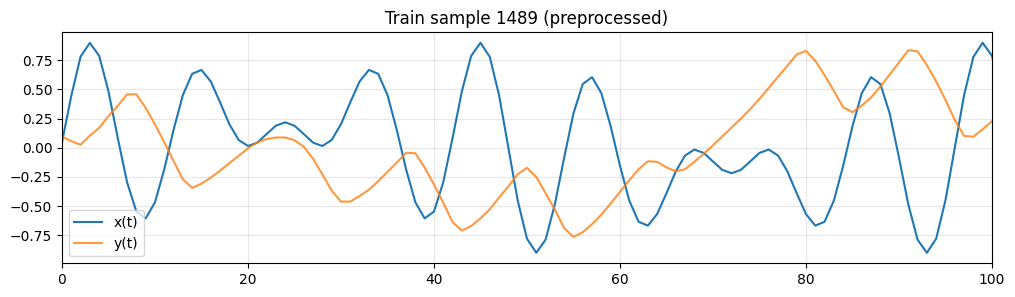

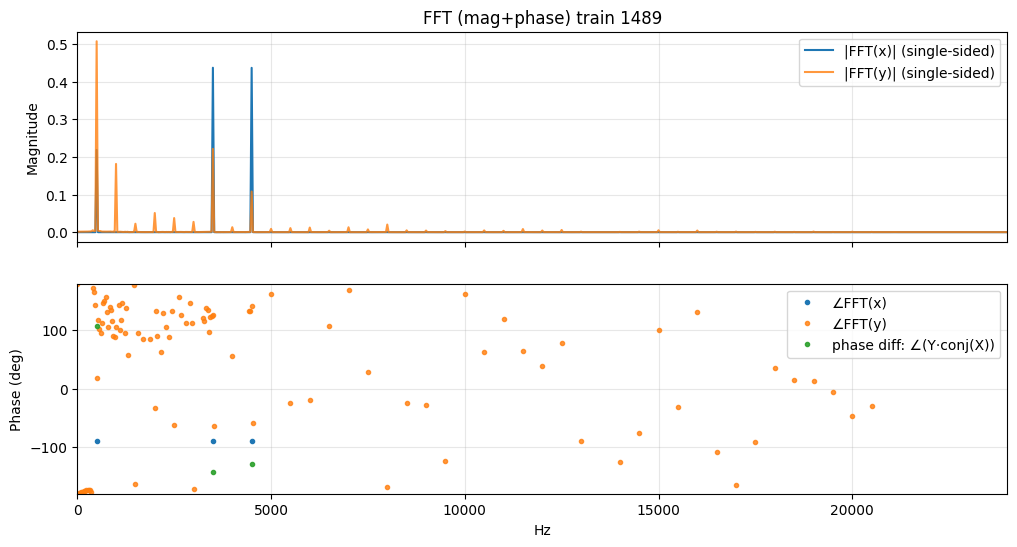

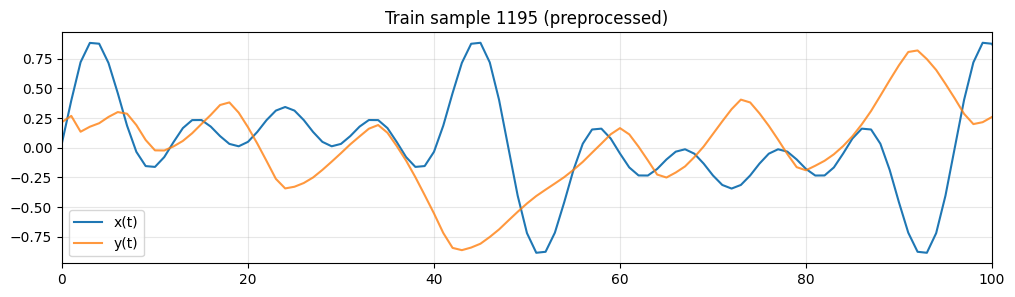

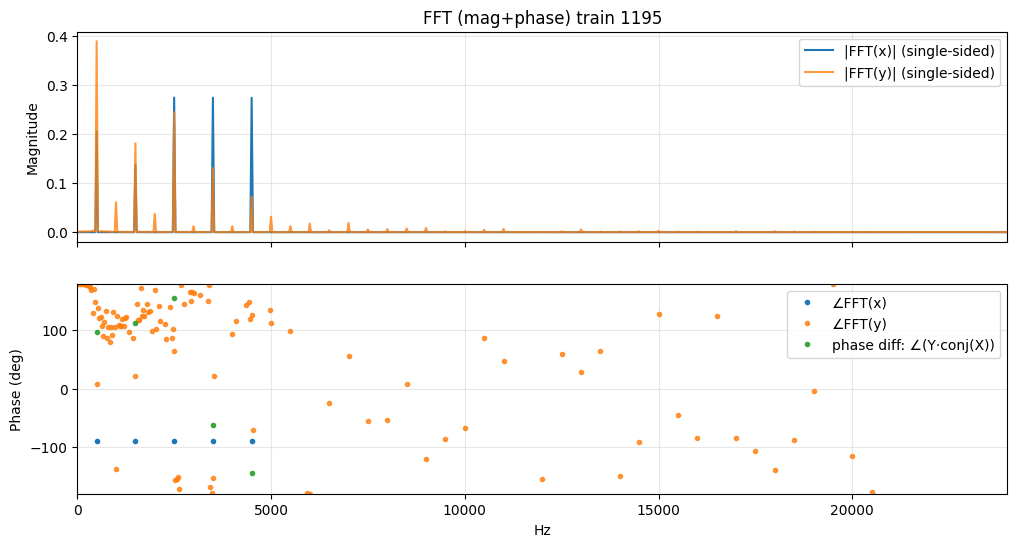

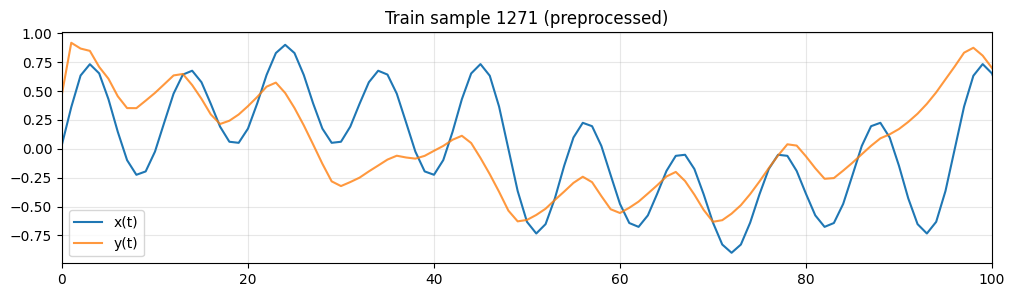

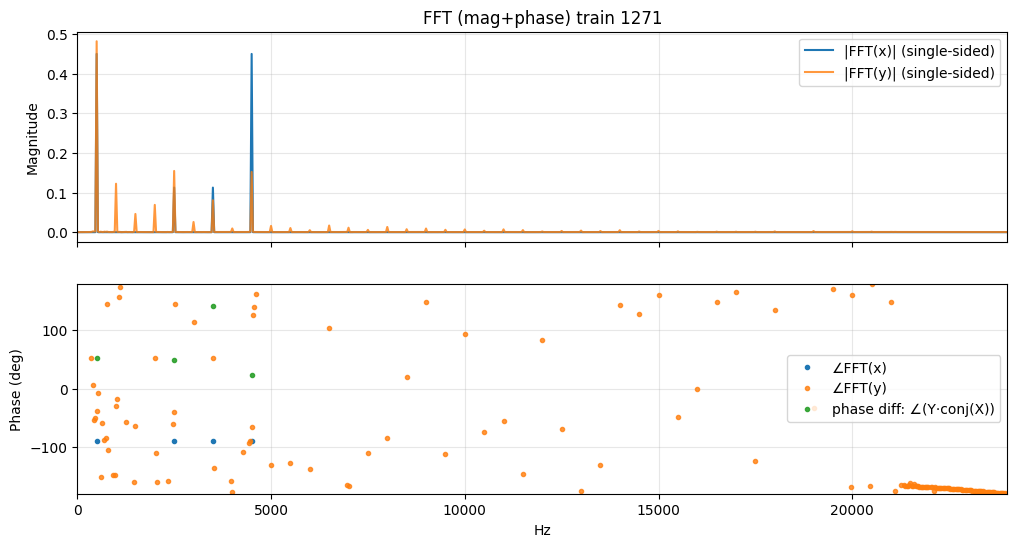

In [9]:

def plot_sample_xy(Xa, Ya, idx=0, title=None, max_points=6000, t_xlim_samples=2000):
    x = Xa[idx, 0]
    y = Ya[idx, 0]
    T = x.shape[-1]
    step = max(1, T // max_points)

    plt.figure(figsize=(12, 3))
    plt.plot(x[::step], label="x(t)")
    plt.plot(y[::step], label="y(t)", alpha=0.8)
    plt.legend()
    plt.grid(True, alpha=0.3)
    if title:
        plt.title(title)
    # x-axis is sample index after downsample
    # plt.xlim(0, min(t_xlim_samples, T//step))
    plt.xlim(0, 100)
    plt.show()

def plot_fft_mag_phase_linear(x, y, fs, title=None, f_xlim=24000, mag_floor_db=-60, show_phase_diff=True):
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    N = len(x)

    Xf = np.fft.rfft(x)
    Yf = np.fft.rfft(y)
    f  = np.fft.rfftfreq(N, d=1.0/fs)

    magX = np.abs(Xf) / N
    magY = np.abs(Yf) / N
    if magX.size > 2:
        magX[1:-1] *= 2
        magY[1:-1] *= 2

    phX = np.rad2deg(np.angle(Xf))
    phY = np.rad2deg(np.angle(Yf))
    if show_phase_diff:
        phD = np.rad2deg(np.angle(Yf * np.conj(Xf)))

    def db(a): return 20*np.log10(np.maximum(a, 1e-12))
    thrX = db(magX).max() + mag_floor_db
    thrY = db(magY).max() + mag_floor_db
    mX = db(magX) >= thrX
    mY = db(magY) >= thrY

    phX_plot = np.where(mX, phX, np.nan)
    phY_plot = np.where(mY, phY, np.nan)
    if show_phase_diff:
        mD = mX & mY
        phD_plot = np.where(mD, phD, np.nan)

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    ax[0].plot(f, magX, label="|FFT(x)| (single-sided)")
    ax[0].plot(f, magY, label="|FFT(y)| (single-sided)", alpha=0.8)
    ax[0].set_ylabel("Magnitude")
    ax[0].grid(True, alpha=0.3)
    ax[0].legend()
    if title:
        ax[0].set_title(title)

    ax[1].plot(f, phX_plot, ".", label="∠FFT(x)")
    ax[1].plot(f, phY_plot, ".", label="∠FFT(y)", alpha=0.8)
    if show_phase_diff:
        ax[1].plot(f, phD_plot, ".", label="phase diff: ∠(Y·conj(X))", alpha=0.9)

    ax[1].set_ylabel("Phase (deg)")
    ax[1].set_xlabel("Hz")
    ax[1].set_ylim(-180, 180)
    ax[1].grid(True, alpha=0.3)
    ax[1].legend()

    ax[1].set_xlim(0, f_xlim)
    plt.show()

for _ in range(3):
    i = np.random.randint(0, X_train_n.shape[0])
    plot_sample_xy(X_train_n, Y_train_n, idx=i, title=f"Train sample {i} (preprocessed)")
    plot_fft_mag_phase_linear(X_train_n[i,0], Y_train_n[i,0], fs=fs, title=f"FFT (mag+phase) train {i}")


## 6) Dataset + DataLoaders

In [10]:

class XYDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.Y[i]

ds_train = XYDataset(X_train_n, Y_train_n)
ds_val   = XYDataset(X_val_n,   Y_val_n)
ds_test  = XYDataset(X_test_n,  Y_test_n)

dl_train = DataLoader(ds_train, batch_size=cfg_split.batch_size, shuffle=True,
                      num_workers=cfg_split.num_workers, pin_memory=cfg_split.pin_memory)
dl_val   = DataLoader(ds_val, batch_size=cfg_split.batch_size, shuffle=False,
                      num_workers=cfg_split.num_workers, pin_memory=cfg_split.pin_memory)
dl_test  = DataLoader(ds_test, batch_size=cfg_split.batch_size, shuffle=False,
                      num_workers=cfg_split.num_workers, pin_memory=cfg_split.pin_memory)

len(ds_train), len(ds_val), len(ds_test)


(1857, 232, 233)

## 7) Pure FNO-1D model (NeuralOperator)

Tries NeuralOperator first; falls back if import path differs.


In [13]:
class GainWrapper(nn.Module):
    def __init__(self, base_model, init_gain=1.0, init_sign=1.0):
        super().__init__()
        self.base = base_model
        self.log_gain = nn.Parameter(torch.tensor(float(np.log(init_gain)), dtype=torch.float32))
        # sign을 연속값으로 학습시키고 tanh로 -1~1로 제한
        self.sign_raw = nn.Parameter(torch.tensor(float(np.arctanh(0.9*init_sign)), dtype=torch.float32))

    def forward(self, x):
        gain = torch.exp(self.log_gain) * torch.tanh(self.sign_raw)
        return self.base(x) * gain


def build_fno1d(in_channels: int, out_channels: int,
               n_modes: int = 64, hidden_channels: int = 64,
               n_layers: int = 4):
    try:
        import neuralop  # noqa: F401
        try:
            from neuralop.models import FNO1d
            return FNO1d(
                n_modes=n_modes,
                hidden_channels=hidden_channels,
                in_channels=in_channels,
                out_channels=out_channels,
                n_layers=n_layers
            )
        except Exception:
            pass
        try:
            from neuralop.models.fno import FNO
            return FNO(
                n_modes=(n_modes,),
                hidden_channels=hidden_channels,
                in_channels=in_channels,
                out_channels=out_channels,
                n_layers=n_layers
            )
        except Exception:
            pass
    except Exception:
        pass

    print("WARNING: NeuralOperator import failed. Using minimal custom FNO-like baseline.")

    class SpectralConv1d(nn.Module):
        def __init__(self, in_ch, out_ch, modes):
            super().__init__()
            self.modes = modes
            self.weight = nn.Parameter(torch.randn(in_ch, out_ch, modes, 2) * 0.02)

        def forward(self, x):
            B, C, T = x.shape
            x_ft = torch.fft.rfft(x, dim=-1)
            out_ft = torch.zeros(B, self.weight.shape[1], x_ft.size(-1), device=x.device, dtype=torch.cfloat)
            modes = min(self.modes, x_ft.size(-1))
            w = torch.view_as_complex(self.weight[..., :modes, :])
            out_ft[..., :modes] = torch.einsum("bim,iom->bom", x_ft[..., :modes], w)
            return torch.fft.irfft(out_ft, n=T, dim=-1)

    class MiniFNO1d(nn.Module):
        def __init__(self, in_ch, out_ch, modes=64, width=64, n_layers=4):
            super().__init__()
            self.lift = nn.Conv1d(in_ch, width, 1)
            self.spec = nn.ModuleList([SpectralConv1d(width, width, modes) for _ in range(n_layers)])
            self.w = nn.ModuleList([nn.Conv1d(width, width, 1) for _ in range(n_layers)])
            self.act = nn.GELU()
            self.proj = nn.Sequential(
                nn.Conv1d(width, width, 1),
                nn.GELU(),
                nn.Conv1d(width, out_ch, 1),
            )
        def forward(self, x):
            x = self.lift(x)
            for spec, w in zip(self.spec, self.w):
                x = self.act(spec(x) + w(x))
            return self.proj(x)

    return MiniFNO1d(in_channels, out_channels, modes=n_modes, width=hidden_channels, n_layers=n_layers)

@dataclass
class ModelConfig:
    n_modes: int = 1024
    hidden_channels: int = 64
    n_layers: int = 4

cfg_model = ModelConfig()

in_ch  = X_train_n.shape[1]
out_ch = Y_train_n.shape[1]

model = build_fno1d(in_channels=in_ch, out_channels=out_ch,
                    n_modes=cfg_model.n_modes,
                    hidden_channels=cfg_model.hidden_channels,
                    n_layers=cfg_model.n_layers).to(device)
# model = GainWrapper(model, init_gain=1.0, init_sign=1.0).to(device)

print("Model:", model.__class__.__name__)
print(model)

Model: FNO
FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 513]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 1, 

## 8) Training

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch    1 | train 0.158716 | val 0.157587 | lr 1.00e-03
alpha (scale needed): -22.959367752075195


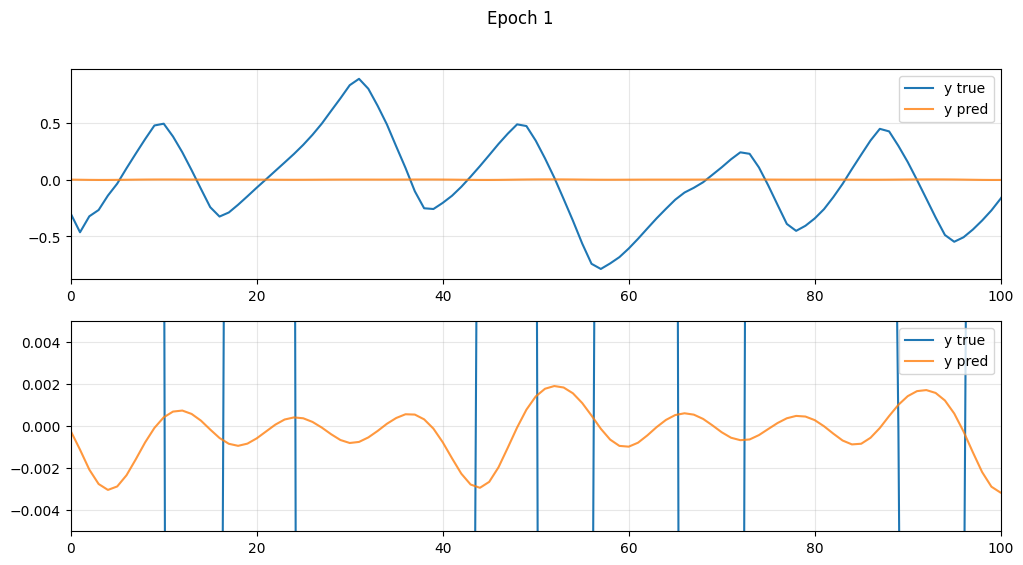

Training:   1%|          | 2/200 [00:04<07:20,  2.23s/it]

Epoch    2 | train 0.158666 | val 0.157576 | lr 1.00e-03


Training:   2%|▏         | 3/200 [00:06<07:06,  2.17s/it]

Epoch    3 | train 0.158663 | val 0.157563 | lr 9.99e-04


Training:   2%|▏         | 4/200 [00:08<06:58,  2.13s/it]

Epoch    4 | train 0.158665 | val 0.157558 | lr 9.99e-04


Training:   2%|▎         | 5/200 [00:10<06:51,  2.11s/it]

Epoch    5 | train 0.158659 | val 0.157556 | lr 9.98e-04


Training:   3%|▎         | 6/200 [00:12<06:46,  2.09s/it]

Epoch    6 | train 0.158661 | val 0.157555 | lr 9.98e-04


Training:   4%|▎         | 7/200 [00:14<06:41,  2.08s/it]

Epoch    7 | train 0.158660 | val 0.157557 | lr 9.97e-04


Training:   4%|▍         | 8/200 [00:16<06:37,  2.07s/it]

Epoch    8 | train 0.158658 | val 0.157556 | lr 9.96e-04


Training:   4%|▍         | 9/200 [00:18<06:34,  2.06s/it]

Epoch    9 | train 0.158658 | val 0.157555 | lr 9.95e-04
Epoch   10 | train 0.158659 | val 0.157556 | lr 9.94e-04
alpha (scale needed): -2.168879747390747


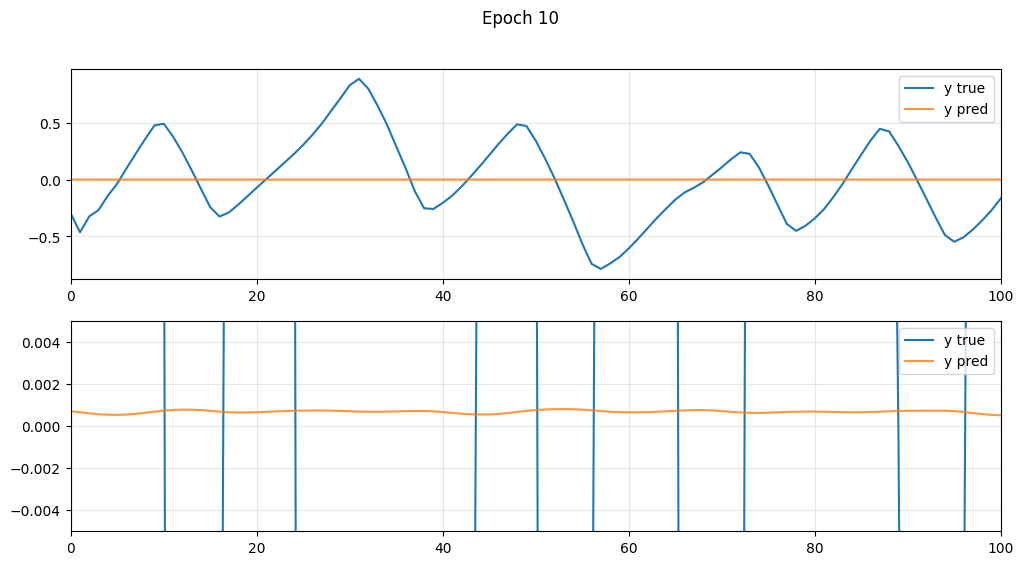

Training:   6%|▌         | 11/200 [00:23<06:32,  2.08s/it]

Epoch   11 | train 0.158664 | val 0.157566 | lr 9.93e-04


Training:   6%|▌         | 12/200 [00:25<06:28,  2.07s/it]

Epoch   12 | train 0.158661 | val 0.157559 | lr 9.91e-04


Training:   6%|▋         | 13/200 [00:27<06:25,  2.06s/it]

Epoch   13 | train 0.158658 | val 0.157562 | lr 9.90e-04


Training:   7%|▋         | 14/200 [00:29<06:23,  2.06s/it]

Epoch   14 | train 0.158658 | val 0.157563 | lr 9.88e-04


Training:   8%|▊         | 15/200 [00:31<06:22,  2.07s/it]

Epoch   15 | train 0.158658 | val 0.157560 | lr 9.86e-04


Training:   8%|▊         | 16/200 [00:33<06:21,  2.07s/it]

Epoch   16 | train 0.158658 | val 0.157568 | lr 9.84e-04


Training:   8%|▊         | 17/200 [00:35<06:18,  2.07s/it]

Epoch   17 | train 0.158667 | val 0.157558 | lr 9.82e-04


Training:   9%|▉         | 18/200 [00:37<06:15,  2.07s/it]

Epoch   18 | train 0.158658 | val 0.157557 | lr 9.80e-04


Training:  10%|▉         | 19/200 [00:39<06:13,  2.06s/it]

Epoch   19 | train 0.158657 | val 0.157558 | lr 9.78e-04
Epoch   20 | train 0.158658 | val 0.157557 | lr 9.76e-04
alpha (scale needed): -7.873046398162842


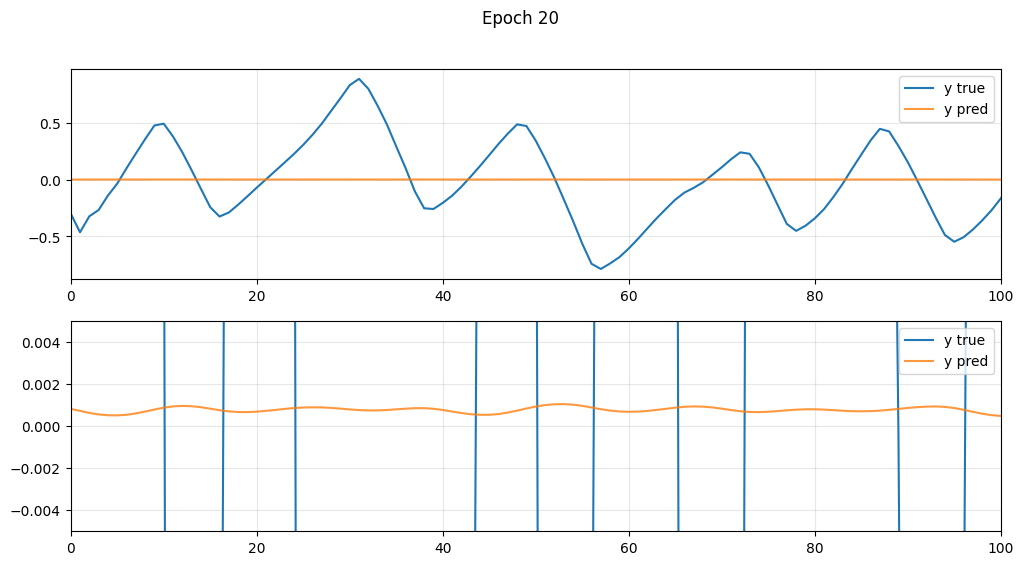

Training:  10%|█         | 21/200 [00:43<06:13,  2.09s/it]

Epoch   21 | train 0.158658 | val 0.157556 | lr 9.73e-04


Training:  11%|█         | 22/200 [00:45<06:10,  2.08s/it]

Epoch   22 | train 0.158657 | val 0.157558 | lr 9.70e-04


Training:  12%|█▏        | 23/200 [00:48<06:06,  2.07s/it]

Epoch   23 | train 0.158658 | val 0.157559 | lr 9.68e-04


Training:  12%|█▏        | 24/200 [00:50<06:04,  2.07s/it]

Epoch   24 | train 0.158659 | val 0.157557 | lr 9.65e-04


Training:  12%|█▎        | 25/200 [00:52<06:01,  2.07s/it]

Epoch   25 | train 0.158657 | val 0.157557 | lr 9.62e-04


Training:  13%|█▎        | 26/200 [00:54<05:59,  2.07s/it]

Epoch   26 | train 0.158659 | val 0.157557 | lr 9.59e-04


Training:  14%|█▎        | 27/200 [00:56<05:57,  2.07s/it]

Epoch   27 | train 0.158657 | val 0.157559 | lr 9.56e-04


Training:  14%|█▍        | 28/200 [00:58<05:55,  2.07s/it]

Epoch   28 | train 0.158659 | val 0.157558 | lr 9.52e-04


Training:  14%|█▍        | 29/200 [01:00<05:53,  2.07s/it]

Epoch   29 | train 0.158658 | val 0.157557 | lr 9.49e-04
Epoch   30 | train 0.158657 | val 0.157558 | lr 9.46e-04
alpha (scale needed): -84.34158325195312


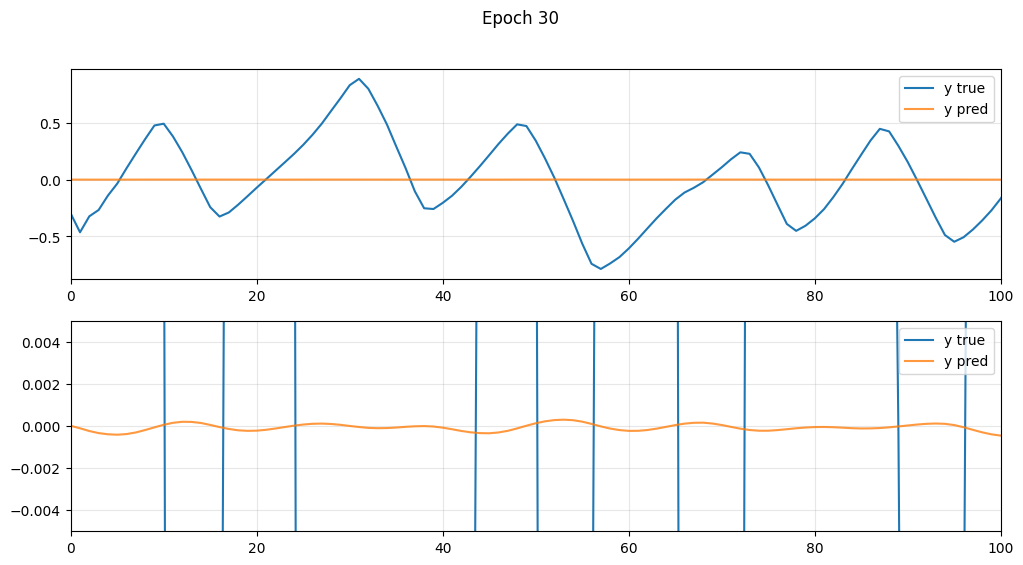

Training:  16%|█▌        | 31/200 [01:04<05:51,  2.08s/it]

Epoch   31 | train 0.158657 | val 0.157556 | lr 9.42e-04


Training:  16%|█▌        | 32/200 [01:06<05:49,  2.08s/it]

Epoch   32 | train 0.158657 | val 0.157556 | lr 9.38e-04


Training:  16%|█▋        | 33/200 [01:08<05:46,  2.07s/it]

Epoch   33 | train 0.158657 | val 0.157557 | lr 9.34e-04


Training:  17%|█▋        | 34/200 [01:10<05:42,  2.06s/it]

Epoch   34 | train 0.158657 | val 0.157560 | lr 9.30e-04


Training:  18%|█▊        | 35/200 [01:12<05:39,  2.06s/it]

Epoch   35 | train 0.158658 | val 0.157558 | lr 9.26e-04


Training:  18%|█▊        | 36/200 [01:14<05:37,  2.06s/it]

Epoch   36 | train 0.158660 | val 0.157556 | lr 9.22e-04


Training:  18%|█▊        | 37/200 [01:16<05:35,  2.06s/it]

Epoch   37 | train 0.158657 | val 0.157555 | lr 9.18e-04


Training:  19%|█▉        | 38/200 [01:18<05:32,  2.05s/it]

Epoch   38 | train 0.158657 | val 0.157556 | lr 9.14e-04


Training:  20%|█▉        | 39/200 [01:21<05:30,  2.05s/it]

Epoch   39 | train 0.158657 | val 0.157558 | lr 9.09e-04
Epoch   40 | train 0.158658 | val 0.157558 | lr 9.05e-04
alpha (scale needed): -12.285561561584473


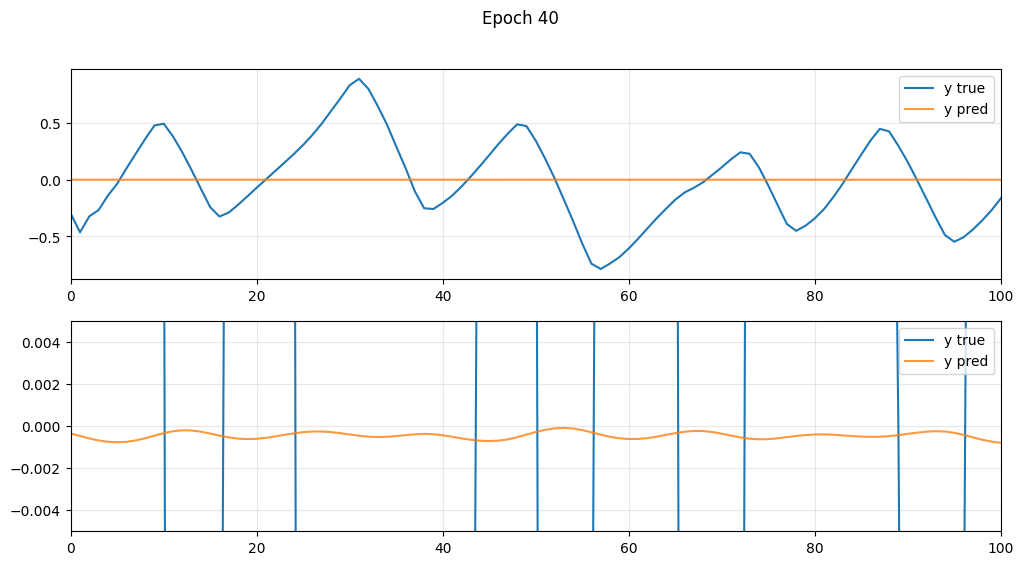

Training:  20%|██        | 41/200 [01:25<05:40,  2.14s/it]

Epoch   41 | train 0.158657 | val 0.157557 | lr 9.00e-04


Training:  21%|██        | 42/200 [01:27<05:35,  2.13s/it]

Epoch   42 | train 0.158657 | val 0.157559 | lr 8.95e-04


Training:  22%|██▏       | 43/200 [01:29<05:31,  2.11s/it]

Epoch   43 | train 0.158661 | val 0.157556 | lr 8.90e-04


Training:  22%|██▏       | 44/200 [01:31<05:27,  2.10s/it]

Epoch   44 | train 0.158658 | val 0.157557 | lr 8.85e-04


Training:  22%|██▎       | 45/200 [01:33<05:24,  2.10s/it]

Epoch   45 | train 0.158657 | val 0.157559 | lr 8.80e-04


Training:  23%|██▎       | 46/200 [01:35<05:23,  2.10s/it]

Epoch   46 | train 0.158660 | val 0.157556 | lr 8.75e-04


Training:  24%|██▎       | 47/200 [01:38<05:19,  2.09s/it]

Epoch   47 | train 0.158657 | val 0.157557 | lr 8.70e-04


Training:  24%|██▍       | 48/200 [01:40<05:24,  2.14s/it]

Epoch   48 | train 0.158657 | val 0.157558 | lr 8.64e-04


Training:  24%|██▍       | 49/200 [01:42<05:28,  2.18s/it]

Epoch   49 | train 0.158657 | val 0.157559 | lr 8.59e-04
Epoch   50 | train 0.158694 | val 0.157552 | lr 8.54e-04
alpha (scale needed): 53.18052291870117


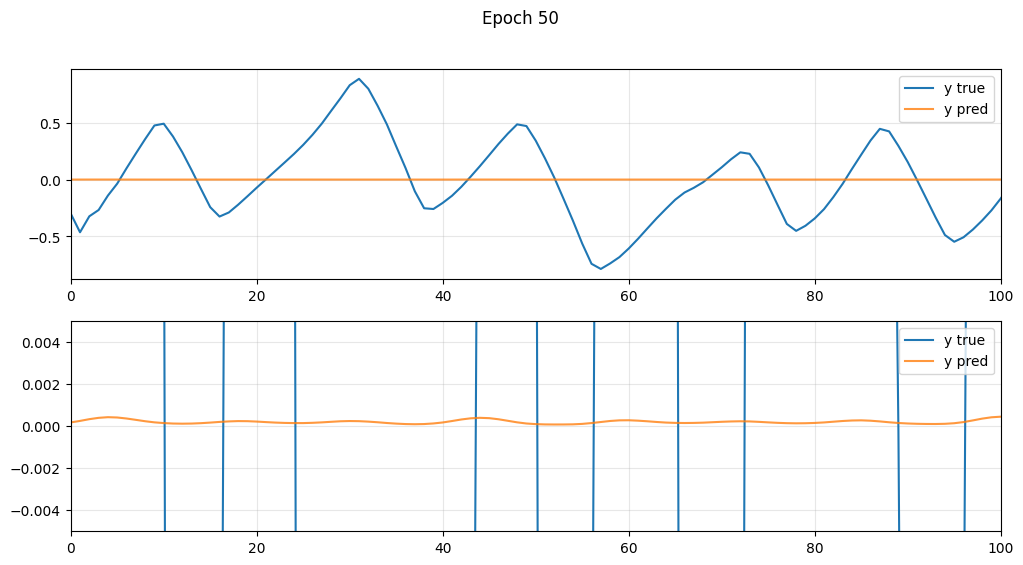

Training:  26%|██▌       | 51/200 [01:47<05:36,  2.26s/it]

Epoch   51 | train 0.158659 | val 0.157556 | lr 8.48e-04


Training:  26%|██▌       | 52/200 [01:49<05:34,  2.26s/it]

Epoch   52 | train 0.158657 | val 0.157557 | lr 8.42e-04


Training:  26%|██▋       | 53/200 [01:51<05:35,  2.28s/it]

Epoch   53 | train 0.158658 | val 0.157558 | lr 8.37e-04


Training:  27%|██▋       | 54/200 [01:54<05:33,  2.28s/it]

Epoch   54 | train 0.158657 | val 0.157557 | lr 8.31e-04


Training:  28%|██▊       | 55/200 [01:56<05:34,  2.30s/it]

Epoch   55 | train 0.158657 | val 0.157559 | lr 8.25e-04


Training:  28%|██▊       | 56/200 [01:58<05:32,  2.31s/it]

Epoch   56 | train 0.158657 | val 0.157558 | lr 8.19e-04


Training:  28%|██▊       | 57/200 [02:01<05:32,  2.32s/it]

Epoch   57 | train 0.158657 | val 0.157560 | lr 8.13e-04


Training:  29%|██▉       | 58/200 [02:03<05:24,  2.29s/it]

Epoch   58 | train 0.158657 | val 0.157561 | lr 8.06e-04


Training:  30%|██▉       | 59/200 [02:05<05:19,  2.26s/it]

Epoch   59 | train 0.158657 | val 0.157562 | lr 8.00e-04
Epoch   60 | train 0.158657 | val 0.157562 | lr 7.94e-04
alpha (scale needed): -51.38535690307617


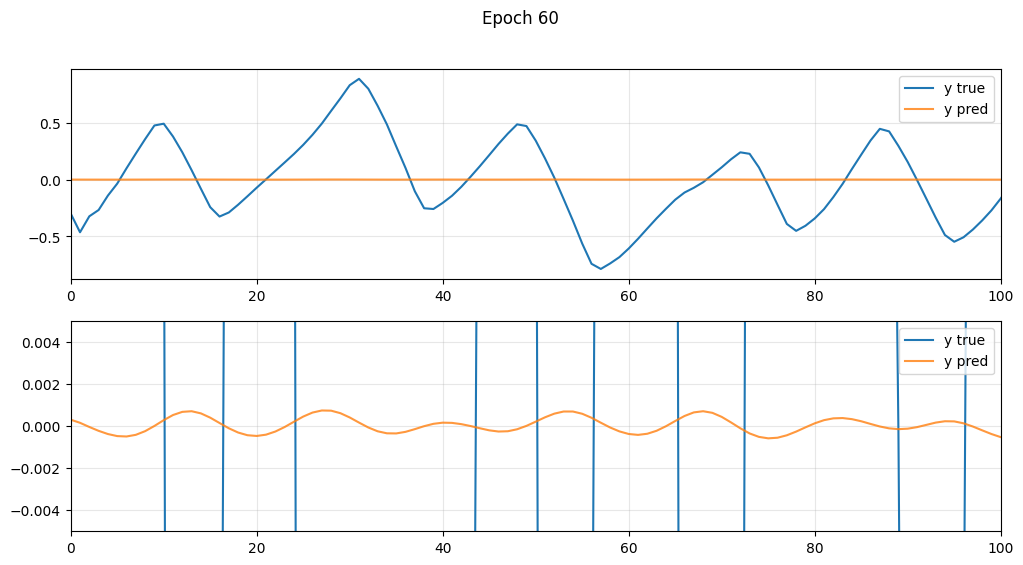

Training:  30%|███       | 61/200 [02:10<05:21,  2.31s/it]

Epoch   61 | train 0.158657 | val 0.157563 | lr 7.88e-04


Training:  31%|███       | 62/200 [02:12<05:18,  2.30s/it]

Epoch   62 | train 0.158659 | val 0.157561 | lr 7.81e-04


Training:  32%|███▏      | 63/200 [02:14<05:10,  2.26s/it]

Epoch   63 | train 0.158657 | val 0.157564 | lr 7.75e-04


Training:  32%|███▏      | 64/200 [02:17<05:08,  2.27s/it]

Epoch   64 | train 0.158657 | val 0.157560 | lr 7.68e-04


Training:  32%|███▎      | 65/200 [02:19<05:06,  2.27s/it]

Epoch   65 | train 0.158657 | val 0.157562 | lr 7.61e-04


Training:  33%|███▎      | 66/200 [02:21<05:04,  2.28s/it]

Epoch   66 | train 0.158657 | val 0.157558 | lr 7.55e-04


Training:  34%|███▎      | 67/200 [02:23<05:04,  2.29s/it]

Epoch   67 | train 0.158657 | val 0.157560 | lr 7.48e-04


Training:  34%|███▍      | 68/200 [02:26<05:02,  2.29s/it]

Epoch   68 | train 0.158658 | val 0.157561 | lr 7.41e-04


Training:  34%|███▍      | 69/200 [02:28<04:59,  2.29s/it]

Epoch   69 | train 0.158657 | val 0.157565 | lr 7.34e-04
Epoch   70 | train 0.158659 | val 0.157567 | lr 7.27e-04
alpha (scale needed): -29.898366928100586


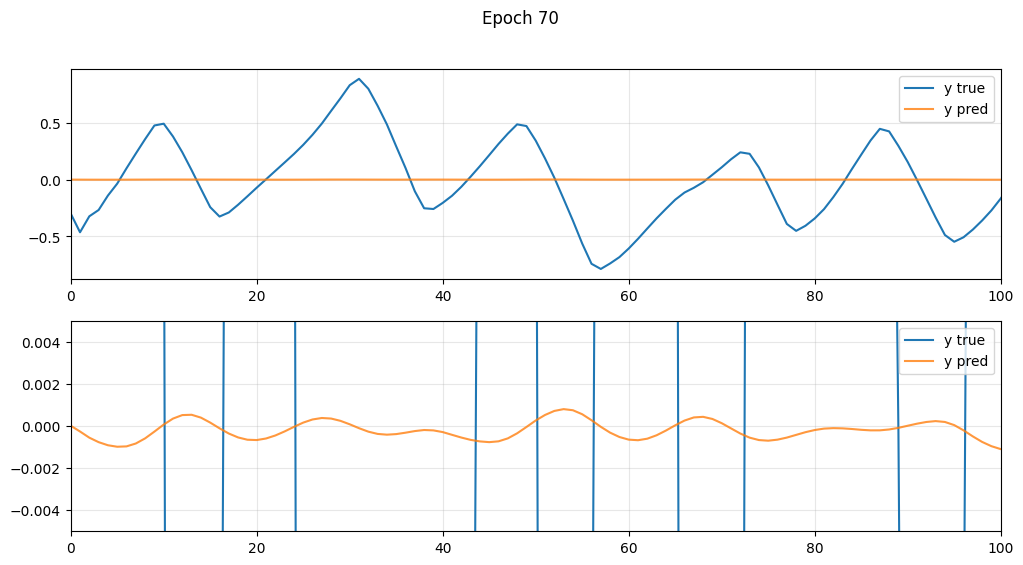

Training:  36%|███▌      | 71/200 [02:32<04:51,  2.26s/it]

Epoch   71 | train 0.158656 | val 0.157579 | lr 7.20e-04


Training:  36%|███▌      | 72/200 [02:35<04:51,  2.28s/it]

Epoch   72 | train 0.158667 | val 0.157559 | lr 7.13e-04


Training:  36%|███▋      | 73/200 [02:37<04:50,  2.29s/it]

Epoch   73 | train 0.158658 | val 0.157566 | lr 7.06e-04


Training:  37%|███▋      | 74/200 [02:39<04:50,  2.30s/it]

Epoch   74 | train 0.158657 | val 0.157566 | lr 6.99e-04


Training:  38%|███▊      | 75/200 [02:42<04:47,  2.30s/it]

Epoch   75 | train 0.158659 | val 0.157561 | lr 6.91e-04


Training:  38%|███▊      | 76/200 [02:44<04:43,  2.28s/it]

Epoch   76 | train 0.158659 | val 0.157570 | lr 6.84e-04


Training:  38%|███▊      | 77/200 [02:46<04:34,  2.23s/it]

Epoch   77 | train 0.158656 | val 0.157576 | lr 6.77e-04


Training:  39%|███▉      | 78/200 [02:48<04:27,  2.20s/it]

Epoch   78 | train 0.158656 | val 0.157574 | lr 6.69e-04


Training:  40%|███▉      | 79/200 [02:50<04:22,  2.17s/it]

Epoch   79 | train 0.158656 | val 0.157587 | lr 6.62e-04
Epoch   80 | train 0.158656 | val 0.157590 | lr 6.55e-04
alpha (scale needed): -46.254913330078125


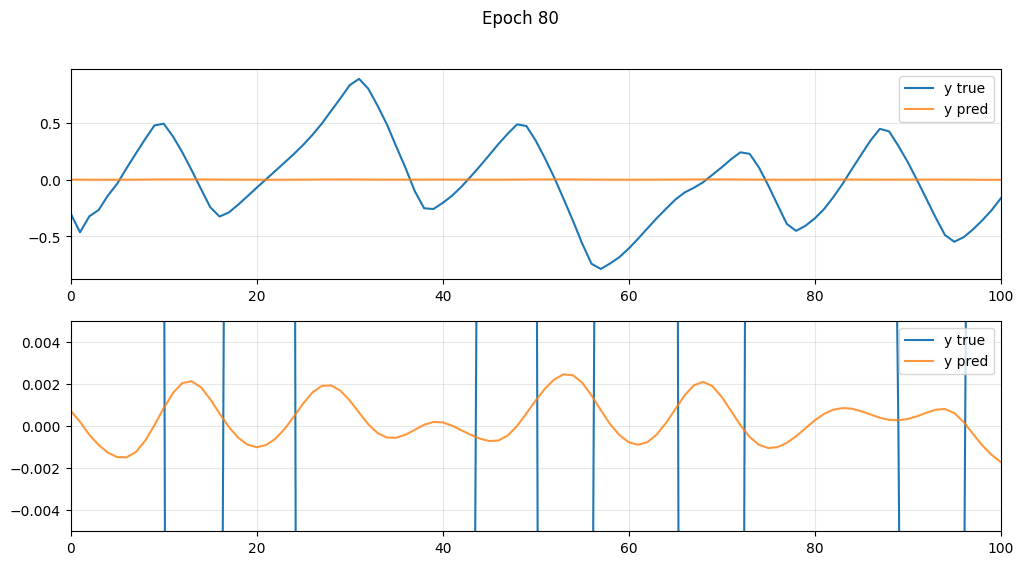

Training:  40%|████      | 81/200 [02:55<04:17,  2.16s/it]

Epoch   81 | train 0.158693 | val 0.157563 | lr 6.47e-04


Training:  41%|████      | 82/200 [02:57<04:13,  2.15s/it]

Epoch   82 | train 0.158657 | val 0.157563 | lr 6.39e-04


Training:  42%|████▏     | 83/200 [02:59<04:09,  2.13s/it]

Epoch   83 | train 0.158657 | val 0.157565 | lr 6.32e-04


Training:  42%|████▏     | 84/200 [03:01<04:05,  2.12s/it]

Epoch   84 | train 0.158656 | val 0.157565 | lr 6.24e-04


Training:  42%|████▎     | 85/200 [03:03<04:02,  2.11s/it]

Epoch   85 | train 0.158655 | val 0.157576 | lr 6.17e-04


Training:  43%|████▎     | 86/200 [03:05<04:00,  2.11s/it]

Epoch   86 | train 0.158655 | val 0.157580 | lr 6.09e-04


Training:  44%|████▎     | 87/200 [03:07<03:58,  2.11s/it]

Epoch   87 | train 0.158658 | val 0.157570 | lr 6.01e-04


Training:  44%|████▍     | 88/200 [03:09<03:55,  2.10s/it]

Epoch   88 | train 0.158655 | val 0.157571 | lr 5.94e-04


Training:  44%|████▍     | 89/200 [03:11<03:51,  2.09s/it]

Epoch   89 | train 0.158662 | val 0.157573 | lr 5.86e-04
Epoch   90 | train 0.158655 | val 0.157571 | lr 5.78e-04
alpha (scale needed): -50.16791915893555


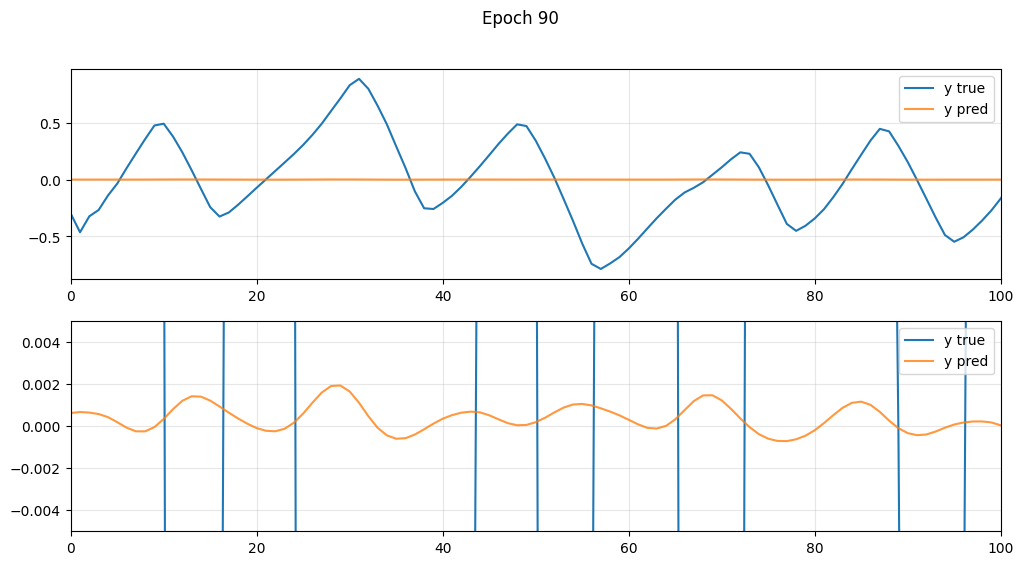

Training:  46%|████▌     | 91/200 [03:16<03:48,  2.10s/it]

Epoch   91 | train 0.158657 | val 0.157577 | lr 5.70e-04


Training:  46%|████▌     | 92/200 [03:18<03:46,  2.10s/it]

Epoch   92 | train 0.158653 | val 0.157578 | lr 5.63e-04


Training:  46%|████▋     | 93/200 [03:20<03:43,  2.09s/it]

Epoch   93 | train 0.158650 | val 0.157583 | lr 5.55e-04


Training:  47%|████▋     | 94/200 [03:22<03:40,  2.08s/it]

Epoch   94 | train 0.158644 | val 0.157585 | lr 5.47e-04


Training:  48%|████▊     | 95/200 [03:24<03:37,  2.07s/it]

Epoch   95 | train 0.158642 | val 0.157553 | lr 5.39e-04


Training:  48%|████▊     | 96/200 [03:26<03:34,  2.06s/it]

Epoch   96 | train 0.158605 | val 0.156954 | lr 5.31e-04


Training:  48%|████▊     | 97/200 [03:28<03:32,  2.06s/it]

Epoch   97 | train 0.158403 | val 0.157180 | lr 5.24e-04


Training:  49%|████▉     | 98/200 [03:30<03:30,  2.06s/it]

Epoch   98 | train 0.157963 | val 0.155719 | lr 5.16e-04


Training:  50%|████▉     | 99/200 [03:32<03:27,  2.06s/it]

Epoch   99 | train 0.157357 | val 0.156285 | lr 5.08e-04
Epoch  100 | train 0.155680 | val 0.155322 | lr 5.00e-04
alpha (scale needed): -1.9328633546829224


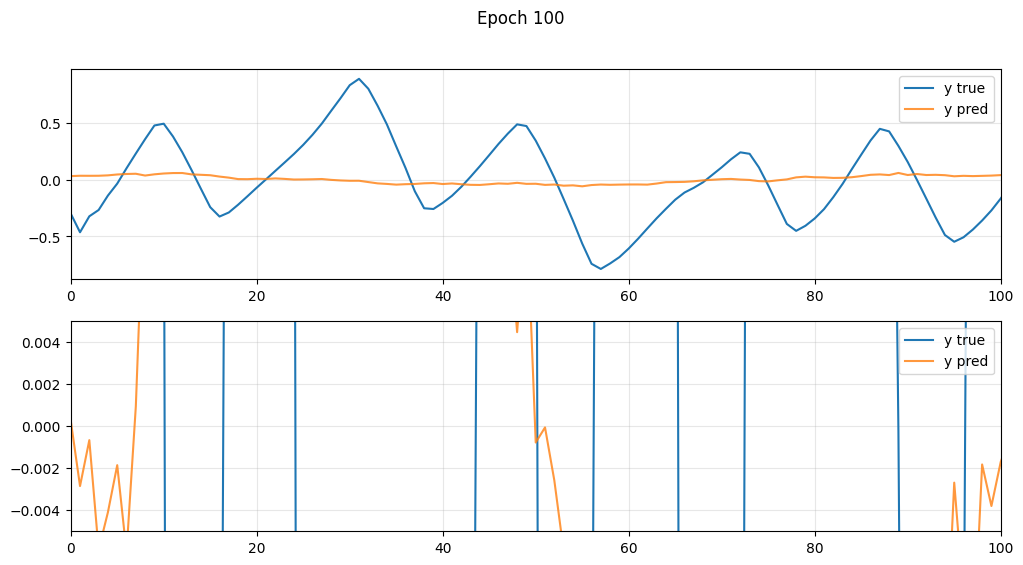

Training:  50%|█████     | 101/200 [03:36<03:25,  2.08s/it]

Epoch  101 | train 0.152428 | val 0.153100 | lr 4.92e-04


Training:  51%|█████     | 102/200 [03:38<03:23,  2.07s/it]

Epoch  102 | train 0.149365 | val 0.150367 | lr 4.84e-04


Training:  52%|█████▏    | 103/200 [03:41<03:24,  2.11s/it]

Epoch  103 | train 0.145467 | val 0.149699 | lr 4.76e-04


Training:  52%|█████▏    | 104/200 [03:43<03:29,  2.18s/it]

Epoch  104 | train 0.141898 | val 0.147894 | lr 4.69e-04


Training:  52%|█████▎    | 105/200 [03:45<03:29,  2.20s/it]

Epoch  105 | train 0.138643 | val 0.151700 | lr 4.61e-04


Training:  53%|█████▎    | 106/200 [03:47<03:28,  2.22s/it]

Epoch  106 | train 0.136943 | val 0.143292 | lr 4.53e-04


Training:  54%|█████▎    | 107/200 [03:50<03:27,  2.23s/it]

Epoch  107 | train 0.132167 | val 0.141511 | lr 4.45e-04


Training:  54%|█████▍    | 108/200 [03:52<03:26,  2.24s/it]

Epoch  108 | train 0.129234 | val 0.143128 | lr 4.37e-04


Training:  55%|█████▍    | 109/200 [03:54<03:25,  2.26s/it]

Epoch  109 | train 0.126379 | val 0.143060 | lr 4.30e-04
Epoch  110 | train 0.125375 | val 0.140098 | lr 4.22e-04
alpha (scale needed): 0.9271757006645203


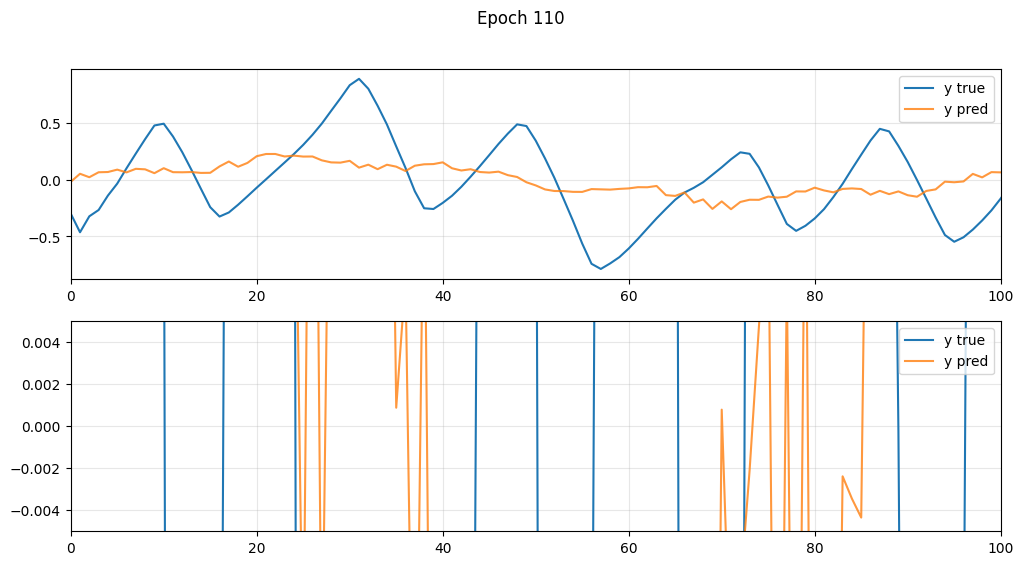

Training:  56%|█████▌    | 111/200 [03:59<03:25,  2.30s/it]

Epoch  111 | train 0.122533 | val 0.137829 | lr 4.14e-04


Training:  56%|█████▌    | 112/200 [04:01<03:22,  2.30s/it]

Epoch  112 | train 0.120531 | val 0.138735 | lr 4.06e-04


Training:  56%|█████▋    | 113/200 [04:04<03:18,  2.28s/it]

Epoch  113 | train 0.119353 | val 0.139333 | lr 3.99e-04


Training:  57%|█████▋    | 114/200 [04:06<03:15,  2.28s/it]

Epoch  114 | train 0.116373 | val 0.137968 | lr 3.91e-04


Training:  57%|█████▊    | 115/200 [04:08<03:08,  2.22s/it]

Epoch  115 | train 0.115320 | val 0.137200 | lr 3.83e-04


Training:  58%|█████▊    | 116/200 [04:10<03:02,  2.18s/it]

Epoch  116 | train 0.111996 | val 0.137275 | lr 3.76e-04


Training:  58%|█████▊    | 117/200 [04:12<02:58,  2.15s/it]

Epoch  117 | train 0.112782 | val 0.137222 | lr 3.68e-04


Training:  59%|█████▉    | 118/200 [04:14<02:53,  2.12s/it]

Epoch  118 | train 0.109398 | val 0.141008 | lr 3.61e-04


Training:  60%|█████▉    | 119/200 [04:16<02:50,  2.11s/it]

Epoch  119 | train 0.106191 | val 0.135165 | lr 3.53e-04
Epoch  120 | train 0.103335 | val 0.134253 | lr 3.45e-04
alpha (scale needed): 0.7979437708854675


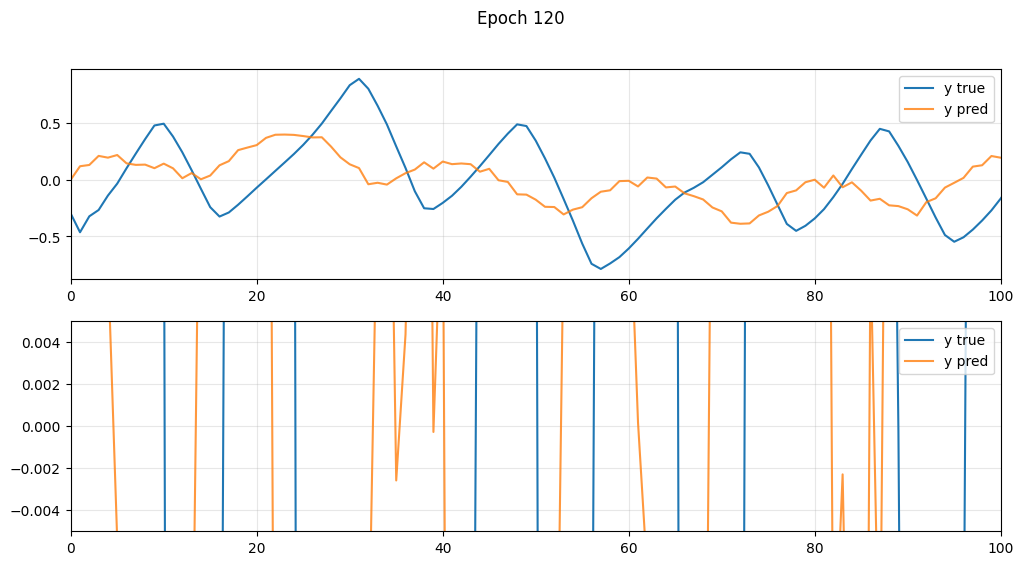

Training:  60%|██████    | 121/200 [04:20<02:46,  2.11s/it]

Epoch  121 | train 0.101435 | val 0.133498 | lr 3.38e-04


Training:  61%|██████    | 122/200 [04:22<02:43,  2.10s/it]

Epoch  122 | train 0.099114 | val 0.134567 | lr 3.31e-04


Training:  62%|██████▏   | 123/200 [04:25<02:41,  2.09s/it]

Epoch  123 | train 0.096199 | val 0.131875 | lr 3.23e-04


Training:  62%|██████▏   | 124/200 [04:27<02:39,  2.09s/it]

Epoch  124 | train 0.092386 | val 0.137386 | lr 3.16e-04


Training:  62%|██████▎   | 125/200 [04:29<02:38,  2.12s/it]

Epoch  125 | train 0.089124 | val 0.138622 | lr 3.09e-04


Training:  63%|██████▎   | 126/200 [04:31<02:39,  2.15s/it]

Epoch  126 | train 0.085198 | val 0.138085 | lr 3.01e-04


Training:  64%|██████▎   | 127/200 [04:33<02:38,  2.18s/it]

Epoch  127 | train 0.080937 | val 0.141380 | lr 2.94e-04


Training:  64%|██████▍   | 128/200 [04:36<02:38,  2.20s/it]

Epoch  128 | train 0.077190 | val 0.137899 | lr 2.87e-04


Training:  64%|██████▍   | 129/200 [04:38<02:38,  2.23s/it]

Epoch  129 | train 0.072319 | val 0.138916 | lr 2.80e-04
Epoch  130 | train 0.067325 | val 0.144825 | lr 2.73e-04
alpha (scale needed): 0.7014678120613098


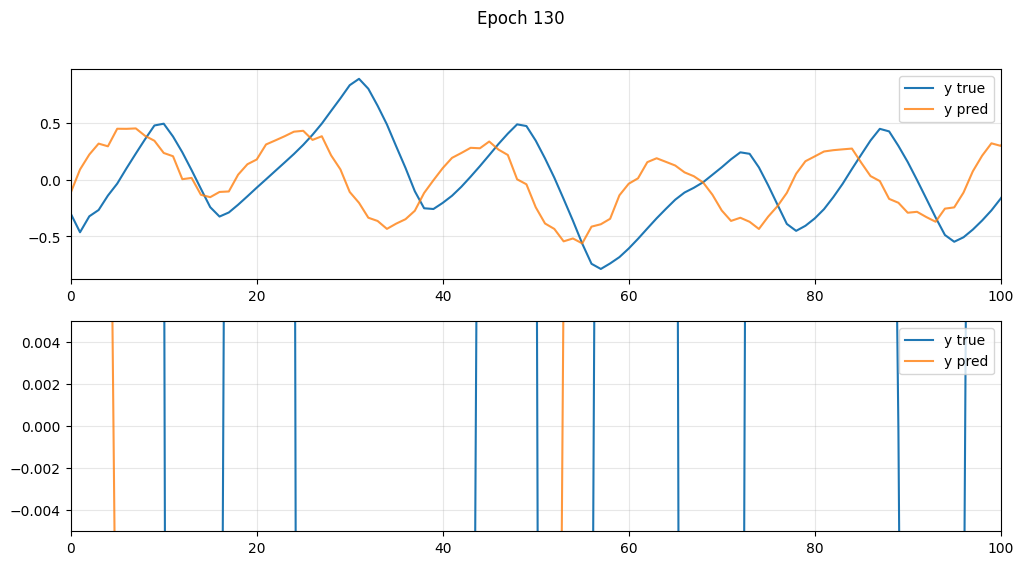

Training:  66%|██████▌   | 131/200 [04:43<02:37,  2.28s/it]

Epoch  131 | train 0.063518 | val 0.151546 | lr 2.66e-04


Training:  66%|██████▌   | 132/200 [04:45<02:36,  2.30s/it]

Epoch  132 | train 0.060027 | val 0.143879 | lr 2.59e-04


Training:  66%|██████▋   | 133/200 [04:47<02:33,  2.30s/it]

Epoch  133 | train 0.054518 | val 0.150481 | lr 2.52e-04


Training:  67%|██████▋   | 134/200 [04:49<02:30,  2.29s/it]

Epoch  134 | train 0.051471 | val 0.151026 | lr 2.45e-04


Training:  68%|██████▊   | 135/200 [04:52<02:27,  2.27s/it]

Epoch  135 | train 0.048739 | val 0.146329 | lr 2.39e-04


Training:  68%|██████▊   | 136/200 [04:54<02:21,  2.21s/it]

Epoch  136 | train 0.044262 | val 0.148296 | lr 2.32e-04


Training:  68%|██████▊   | 137/200 [04:56<02:16,  2.17s/it]

Epoch  137 | train 0.041079 | val 0.146992 | lr 2.25e-04


Training:  69%|██████▉   | 138/200 [04:58<02:13,  2.15s/it]

Epoch  138 | train 0.042700 | val 0.153584 | lr 2.19e-04


Training:  70%|██████▉   | 139/200 [05:00<02:09,  2.12s/it]

Epoch  139 | train 0.036269 | val 0.152602 | lr 2.12e-04
Epoch  140 | train 0.033297 | val 0.154126 | lr 2.06e-04
alpha (scale needed): 0.6754831075668335


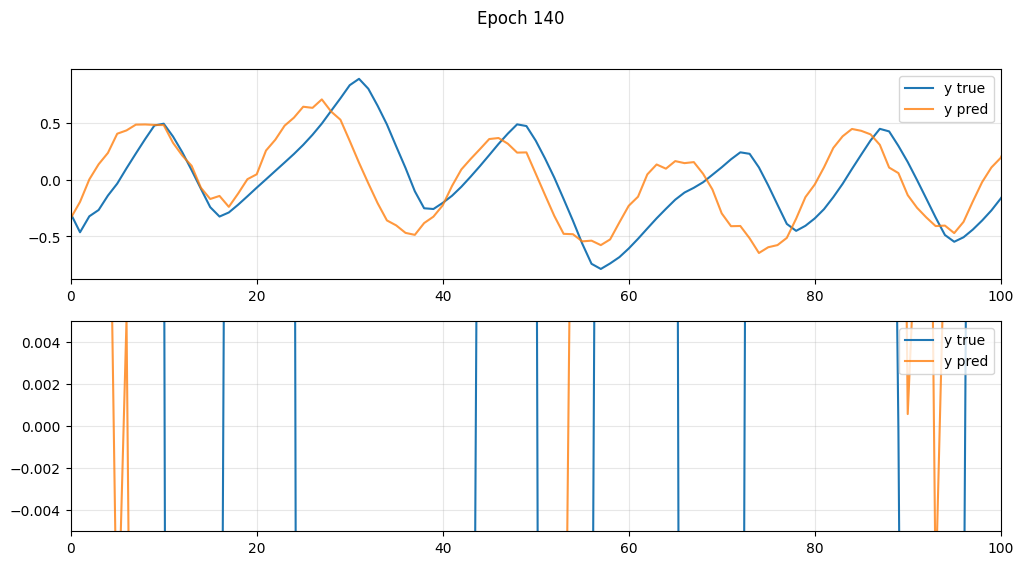

Training:  70%|███████   | 141/200 [05:04<02:05,  2.13s/it]

Epoch  141 | train 0.032083 | val 0.154868 | lr 2.00e-04


Training:  71%|███████   | 142/200 [05:06<02:02,  2.11s/it]

Epoch  142 | train 0.029341 | val 0.155219 | lr 1.94e-04


Training:  72%|███████▏  | 143/200 [05:08<01:59,  2.10s/it]

Epoch  143 | train 0.027502 | val 0.156462 | lr 1.87e-04


Training:  72%|███████▏  | 144/200 [05:10<01:57,  2.09s/it]

Epoch  144 | train 0.026411 | val 0.159981 | lr 1.81e-04


Training:  72%|███████▎  | 145/200 [05:13<01:55,  2.09s/it]

Epoch  145 | train 0.024964 | val 0.154164 | lr 1.75e-04


Training:  73%|███████▎  | 146/200 [05:15<01:52,  2.08s/it]

Epoch  146 | train 0.023859 | val 0.155291 | lr 1.69e-04


Training:  74%|███████▎  | 147/200 [05:17<01:50,  2.08s/it]

Epoch  147 | train 0.022485 | val 0.158680 | lr 1.63e-04


Training:  74%|███████▍  | 148/200 [05:19<01:47,  2.08s/it]

Epoch  148 | train 0.021306 | val 0.157896 | lr 1.58e-04


Training:  74%|███████▍  | 149/200 [05:21<01:46,  2.08s/it]

Epoch  149 | train 0.020082 | val 0.159670 | lr 1.52e-04
Epoch  150 | train 0.019290 | val 0.161855 | lr 1.46e-04
alpha (scale needed): 0.6786307692527771


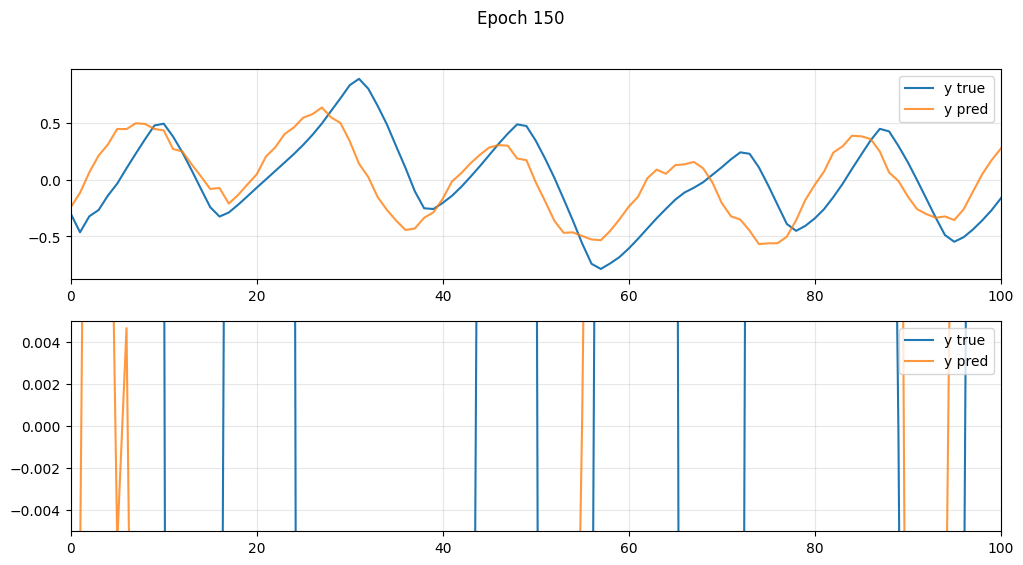

Training:  76%|███████▌  | 151/200 [05:25<01:42,  2.10s/it]

Epoch  151 | train 0.018369 | val 0.162782 | lr 1.41e-04


Training:  76%|███████▌  | 152/200 [05:27<01:40,  2.09s/it]

Epoch  152 | train 0.017657 | val 0.162807 | lr 1.36e-04


Training:  76%|███████▋  | 153/200 [05:29<01:37,  2.08s/it]

Epoch  153 | train 0.017096 | val 0.163648 | lr 1.30e-04


Training:  77%|███████▋  | 154/200 [05:31<01:35,  2.08s/it]

Epoch  154 | train 0.016632 | val 0.163320 | lr 1.25e-04


Training:  78%|███████▊  | 155/200 [05:33<01:33,  2.08s/it]

Epoch  155 | train 0.015886 | val 0.162972 | lr 1.20e-04


Training:  78%|███████▊  | 156/200 [05:35<01:31,  2.07s/it]

Epoch  156 | train 0.014986 | val 0.165870 | lr 1.15e-04


Training:  78%|███████▊  | 157/200 [05:38<01:28,  2.07s/it]

Epoch  157 | train 0.014864 | val 0.165348 | lr 1.10e-04


Training:  79%|███████▉  | 158/200 [05:40<01:26,  2.07s/it]

Epoch  158 | train 0.014052 | val 0.164592 | lr 1.05e-04


Training:  80%|███████▉  | 159/200 [05:42<01:25,  2.08s/it]

Epoch  159 | train 0.013538 | val 0.162610 | lr 1.00e-04
Epoch  160 | train 0.013269 | val 0.165816 | lr 9.55e-05
alpha (scale needed): 0.66404128074646


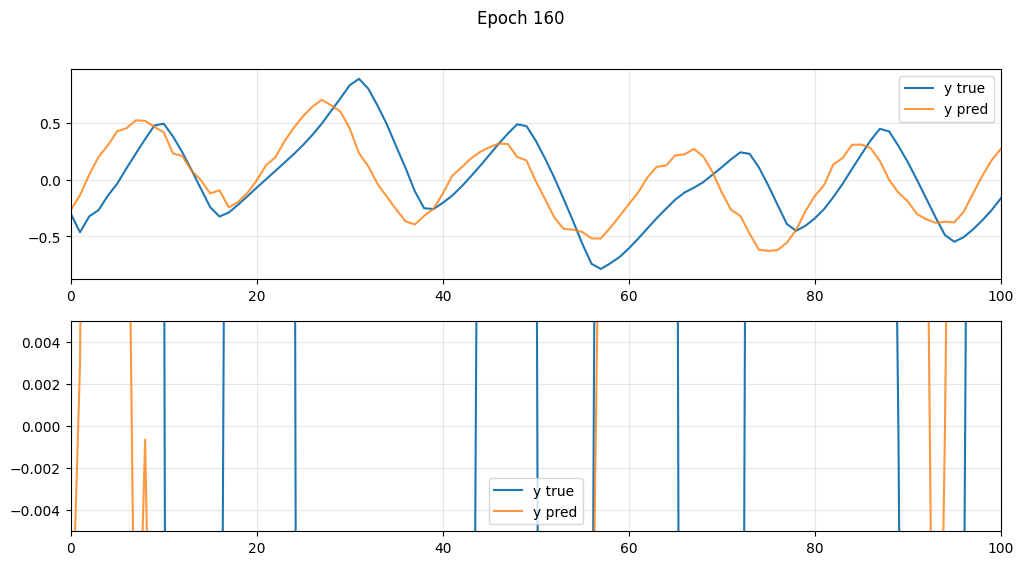

Training:  80%|████████  | 161/200 [05:46<01:21,  2.09s/it]

Epoch  161 | train 0.012864 | val 0.165408 | lr 9.09e-05


Training:  81%|████████  | 162/200 [05:48<01:19,  2.09s/it]

Epoch  162 | train 0.012505 | val 0.166228 | lr 8.65e-05


Training:  82%|████████▏ | 163/200 [05:50<01:17,  2.09s/it]

Epoch  163 | train 0.012110 | val 0.167358 | lr 8.21e-05


Training:  82%|████████▏ | 164/200 [05:52<01:15,  2.10s/it]

Epoch  164 | train 0.011798 | val 0.168931 | lr 7.78e-05


Training:  82%|████████▎ | 165/200 [05:54<01:13,  2.10s/it]

Epoch  165 | train 0.011482 | val 0.167280 | lr 7.37e-05


Training:  83%|████████▎ | 166/200 [05:56<01:11,  2.09s/it]

Epoch  166 | train 0.011168 | val 0.168117 | lr 6.96e-05


Training:  84%|████████▎ | 167/200 [05:58<01:08,  2.09s/it]

Epoch  167 | train 0.010858 | val 0.167950 | lr 6.57e-05


Training:  84%|████████▍ | 168/200 [06:01<01:06,  2.08s/it]

Epoch  168 | train 0.010652 | val 0.168881 | lr 6.18e-05


Training:  84%|████████▍ | 169/200 [06:03<01:04,  2.08s/it]

Epoch  169 | train 0.010452 | val 0.168875 | lr 5.81e-05
Epoch  170 | train 0.010168 | val 0.168989 | lr 5.45e-05
alpha (scale needed): 0.6424341201782227


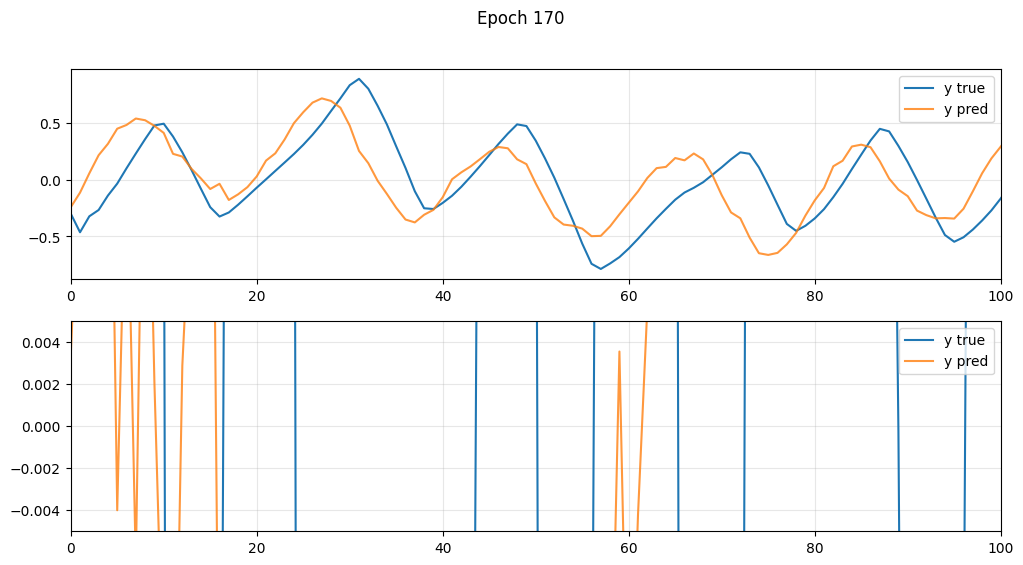

Training:  86%|████████▌ | 171/200 [06:07<01:01,  2.10s/it]

Epoch  171 | train 0.009985 | val 0.168360 | lr 5.10e-05


Training:  86%|████████▌ | 172/200 [06:09<00:58,  2.10s/it]

Epoch  172 | train 0.009819 | val 0.169536 | lr 4.76e-05


Training:  86%|████████▋ | 173/200 [06:11<00:56,  2.10s/it]

Epoch  173 | train 0.009609 | val 0.169157 | lr 4.43e-05


Training:  87%|████████▋ | 174/200 [06:13<00:54,  2.10s/it]

Epoch  174 | train 0.009451 | val 0.171759 | lr 4.11e-05


Training:  88%|████████▊ | 175/200 [06:15<00:52,  2.10s/it]

Epoch  175 | train 0.009422 | val 0.168114 | lr 3.81e-05


Training:  88%|████████▊ | 176/200 [06:17<00:50,  2.09s/it]

Epoch  176 | train 0.009177 | val 0.169161 | lr 3.51e-05


Training:  88%|████████▊ | 177/200 [06:19<00:47,  2.08s/it]

Epoch  177 | train 0.009008 | val 0.170665 | lr 3.23e-05


Training:  89%|████████▉ | 178/200 [06:21<00:45,  2.08s/it]

Epoch  178 | train 0.008877 | val 0.169182 | lr 2.96e-05


Training:  90%|████████▉ | 179/200 [06:24<00:43,  2.07s/it]

Epoch  179 | train 0.008773 | val 0.170050 | lr 2.70e-05
Epoch  180 | train 0.008655 | val 0.169710 | lr 2.45e-05
alpha (scale needed): 0.6363463997840881


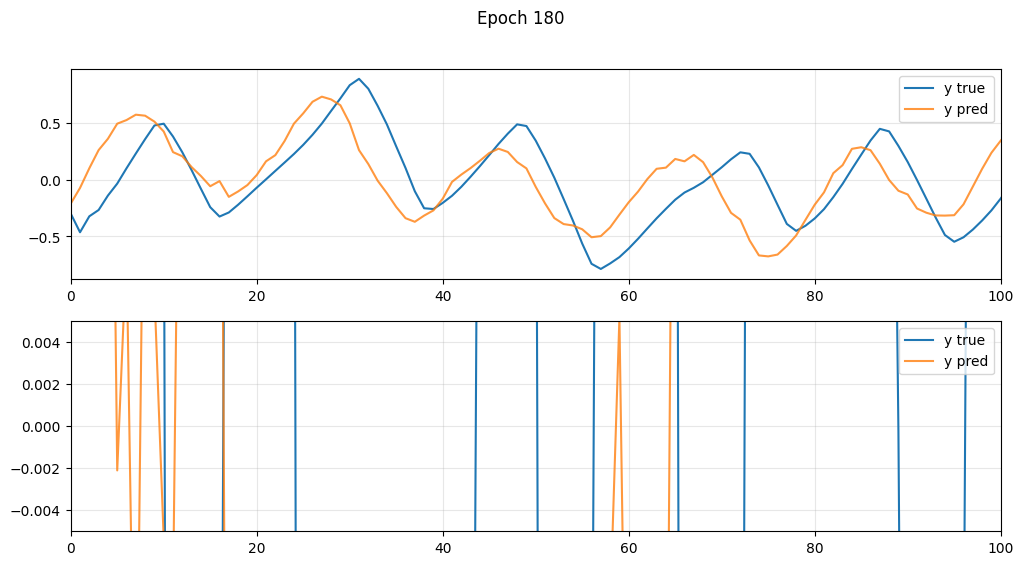

Training:  90%|█████████ | 181/200 [06:28<00:39,  2.09s/it]

Epoch  181 | train 0.008579 | val 0.171222 | lr 2.21e-05


Training:  91%|█████████ | 182/200 [06:30<00:37,  2.09s/it]

Epoch  182 | train 0.009086 | val 0.170422 | lr 1.99e-05


Training:  92%|█████████▏| 183/200 [06:32<00:35,  2.08s/it]

Epoch  183 | train 0.008510 | val 0.169820 | lr 1.77e-05


Training:  92%|█████████▏| 184/200 [06:34<00:33,  2.07s/it]

Epoch  184 | train 0.008385 | val 0.170990 | lr 1.57e-05


Training:  92%|█████████▎| 185/200 [06:36<00:31,  2.07s/it]

Epoch  185 | train 0.008316 | val 0.171018 | lr 1.38e-05


Training:  93%|█████████▎| 186/200 [06:38<00:28,  2.06s/it]

Epoch  186 | train 0.008249 | val 0.170674 | lr 1.20e-05


Training:  94%|█████████▎| 187/200 [06:40<00:26,  2.06s/it]

Epoch  187 | train 0.008196 | val 0.171123 | lr 1.04e-05


Training:  94%|█████████▍| 188/200 [06:42<00:24,  2.07s/it]

Epoch  188 | train 0.008148 | val 0.171190 | lr 8.86e-06


Training:  94%|█████████▍| 189/200 [06:44<00:22,  2.07s/it]

Epoch  189 | train 0.008101 | val 0.171427 | lr 7.45e-06
Epoch  190 | train 0.008071 | val 0.171446 | lr 6.16e-06
alpha (scale needed): 0.629185140132904


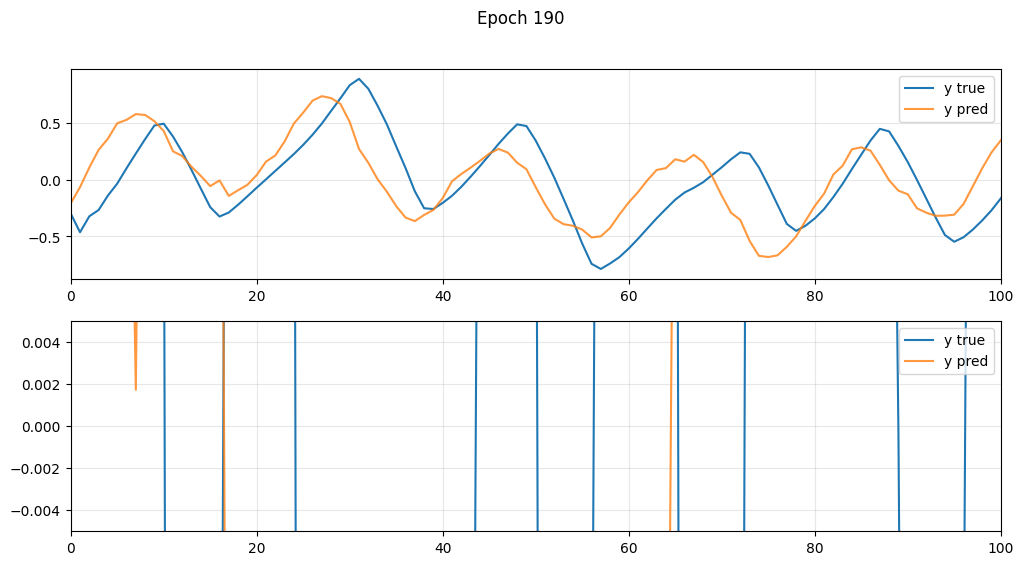

Training:  96%|█████████▌| 191/200 [06:49<00:18,  2.10s/it]

Epoch  191 | train 0.008039 | val 0.171386 | lr 4.99e-06


Training:  96%|█████████▌| 192/200 [06:51<00:16,  2.10s/it]

Epoch  192 | train 0.008012 | val 0.171248 | lr 3.94e-06


Training:  96%|█████████▋| 193/200 [06:53<00:14,  2.10s/it]

Epoch  193 | train 0.007990 | val 0.171061 | lr 3.02e-06


Training:  97%|█████████▋| 194/200 [06:55<00:12,  2.09s/it]

Epoch  194 | train 0.007972 | val 0.171647 | lr 2.22e-06


Training:  98%|█████████▊| 195/200 [06:57<00:10,  2.08s/it]

Epoch  195 | train 0.007959 | val 0.171461 | lr 1.54e-06


Training:  98%|█████████▊| 196/200 [06:59<00:08,  2.08s/it]

Epoch  196 | train 0.007945 | val 0.171342 | lr 9.87e-07


Training:  98%|█████████▊| 197/200 [07:01<00:06,  2.07s/it]

Epoch  197 | train 0.007936 | val 0.171320 | lr 5.55e-07


Training:  99%|█████████▉| 198/200 [07:03<00:04,  2.06s/it]

Epoch  198 | train 0.007930 | val 0.171310 | lr 2.47e-07


Training: 100%|█████████▉| 199/200 [07:05<00:02,  2.06s/it]

Epoch  199 | train 0.007926 | val 0.171312 | lr 6.17e-08
Epoch  200 | train 0.007923 | val 0.171323 | lr 0.00e+00
alpha (scale needed): 0.6295885443687439


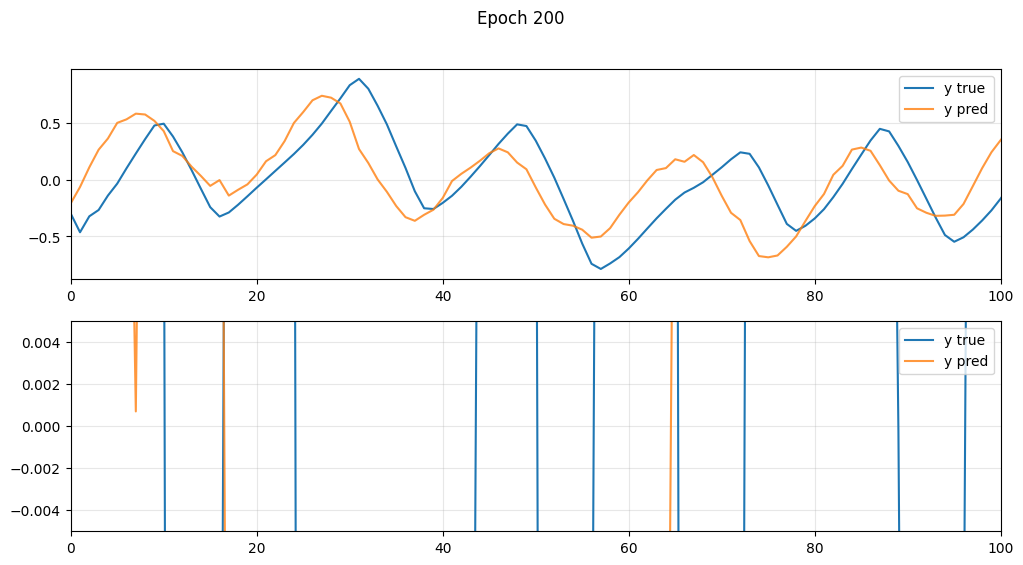

Training: 100%|██████████| 200/200 [07:07<00:00,  2.14s/it]


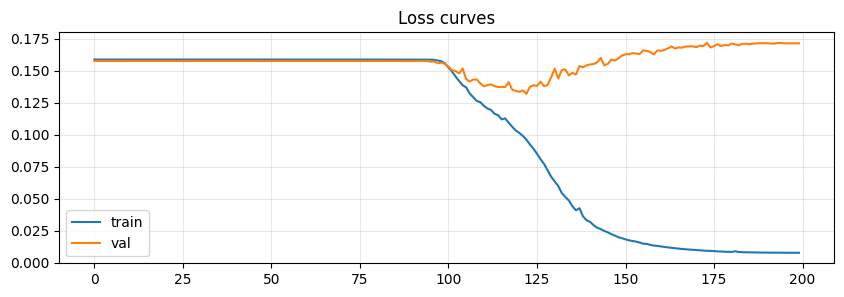

In [ ]:

@dataclass
class TrainConfig:
    epochs: int = 200
    lr: float = 1e-3
    weight_decay: float = 1e-6
    grad_clip: float = None
    seed: int = 42

cfg_train = TrainConfig()

torch.manual_seed(cfg_train.seed)
np.random.seed(cfg_train.seed)
random.seed(cfg_train.seed)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg_train.lr, weight_decay=cfg_train.weight_decay)
# optimizer = torch.optim.AdamW([
#     {"params": model.base.parameters(), "lr": cfg_train.lr, "weight_decay": cfg_train.weight_decay},
#     {"params": [model.log_gain, model.sign_raw], "lr": 1e-2, "weight_decay": 0.0},
# ])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg_train.epochs)

def run_epoch(model, loader, train: bool):
    model.train(train)
    total, n = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = criterion(pred, yb)
        if train:
            loss.backward()
            if cfg_train.grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg_train.grad_clip)
            optimizer.step()
        total += loss.item() * xb.size(0)
        n += xb.size(0)
    return total / max(1, n)

@torch.no_grad()
def visualize_predictions(model, loader, n_show=2, title="Predictions", max_points=6000):
    model.eval()
    xb, yb = next(iter(loader))
    xb = xb.to(device)
    yb = yb.to(device)
    pred = model(xb).detach().cpu().numpy()
    yb = yb.detach().cpu().numpy()

    num = (pred * yb).sum()
    den = (pred * pred).sum() + 1e-12
    alpha = (num / den).item()
    print("alpha (scale needed):", alpha)

    plt.figure(figsize=(12, 3*n_show))
    for i in range(min(n_show, pred.shape[0])):
        T = pred.shape[-1]
        step = max(1, T // max_points)
        plt.subplot(n_show, 1, i+1)
        plt.plot(yb[i,0,::step], label="y true")
        plt.plot(pred[i,0,::step], label="y pred", alpha=0.8)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 100)
    plt.suptitle(title)
    plt.ylim(-0.005, 0.005)
    plt.show()

history = {"train": [], "val": []}

for epoch in tqdm(range(1, cfg_train.epochs + 1), desc="Training"):
    train_loss = run_epoch(model, dl_train, train=True)
    val_loss   = run_epoch(model, dl_val, train=False)
    scheduler.step()

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch:4d} | train {train_loss:.6f} | val {val_loss:.6f} | lr {scheduler.get_last_lr()[0]:.2e}")
    if epoch % 100 == 0:
        visualize_predictions(model, dl_val, n_show=2, title=f"Epoch {epoch}")

plt.figure(figsize=(10, 3))
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Loss curves")
plt.show()


In [15]:
@torch.no_grad()
def debug_scale(model, loader):
    model.eval()
    xb, yb = next(iter(loader))
    xb = xb.to(device); yb = yb.to(device)
    pred = model(xb)

    yt = yb[:,0,:].reshape(-1)
    yp = pred[:,0,:].reshape(-1)

    rms_y  = torch.sqrt(torch.mean(yt**2)).item()
    rms_p  = torch.sqrt(torch.mean(yp**2)).item()
    corr   = ( (yt-yt.mean())*(yp-yp.mean()) ).mean() / (yt.std()*yp.std() + 1e-12)

    alpha = ( (yp*yt).sum() / ( (yp*yp).sum() + 1e-12) ).item()  # your scale-needed

    print("rms_true:", rms_y, "rms_pred:", rms_p, "rms_ratio pred/true:", rms_p/(rms_y+1e-12))
    print("corr:", corr.item() if hasattr(corr, "item") else float(corr))
    print("alpha (true ≈ alpha*pred):", alpha)

debug_scale(model, dl_val)


rms_true: 0.38849982619285583 rms_pred: 0.3490694761276245 rms_ratio pred/true: 0.8985061320296289
corr: 0.5656816959381104
alpha (true ≈ alpha*pred): 0.6295884847640991


## 9) Test evaluation

Test MSE: 0.1495358268590444
alpha (scale needed): 0.6342912316322327


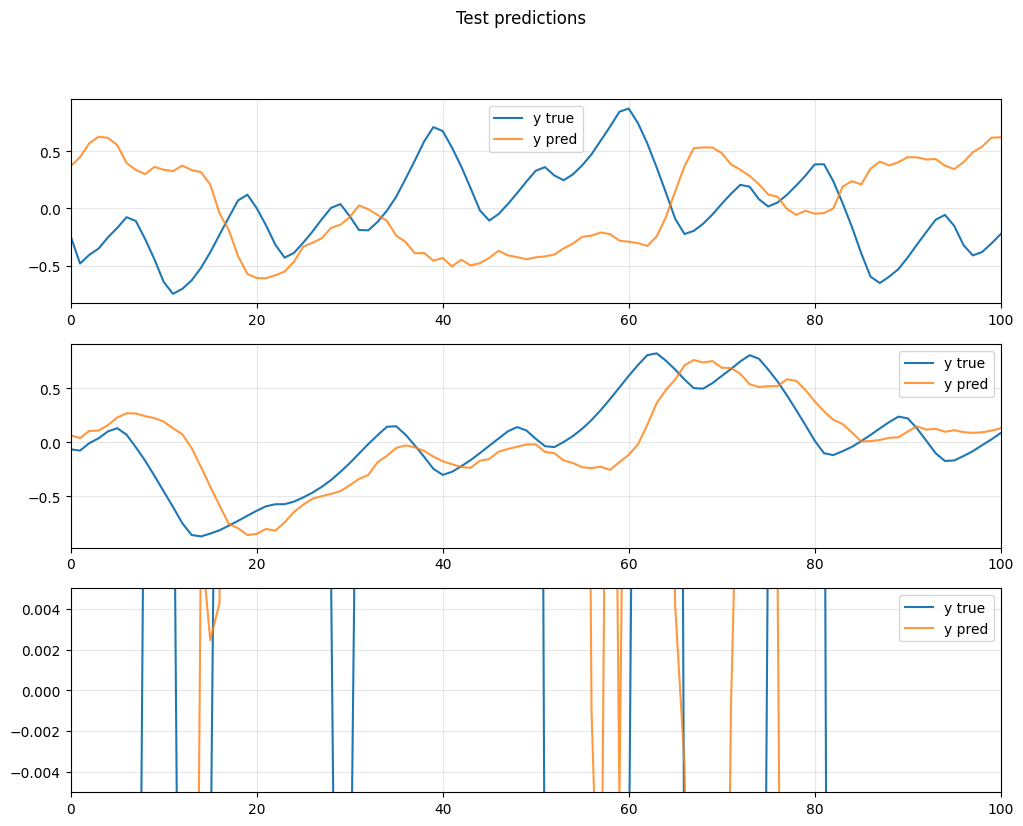

In [16]:

test_loss = run_epoch(model, dl_test, train=False)
print("Test MSE:", test_loss)
visualize_predictions(model, dl_test, n_show=3, title="Test predictions")


## 10) Save model + configs + train-only norm stats

In [ ]:

OUT_DIR = Path("./outputs_fno1d")
OUT_DIR.mkdir(parents=True, exist_ok=True)

ckpt_path = OUT_DIR / "fno1d_x_to_y.pt"
torch.save(model.state_dict(), ckpt_path)

cfg_path = OUT_DIR / "config.json"
bundle = {
    "split": asdict(cfg_split),
    "preproc": asdict(cfg_prep),
    "model": asdict(cfg_model),
    "train": asdict(cfg_train),
    "meta": {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in meta.items()},
    "fs": fs,
    "seg_dur_sec": SEG_DUR_SEC,
}
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(bundle, f, indent=2, ensure_ascii=False)

stats_path = OUT_DIR / "norm_stats_train_only.npz"
if norm_stats is not None:
    np.savez(stats_path, **{k: v for k, v in norm_stats.items() if isinstance(v, np.ndarray)},
             mode=norm_stats.get("mode", "none"))
else:
    np.savez(stats_path, mode="none")

print("Saved:")
print(" -", ckpt_path)
print(" -", cfg_path)
print(" -", stats_path)
